# Cluster analysis

This notebook serves to visualize clusters extracted from the sales data.
Clustering can be done by any of the following methods:
* Dimentionality reduction followed by clustering using HDBCAN
* Self-Organizing Maps
* Dynamic Time Wapring Distance calculation followed by agglomerative clustering

Each of these techniques can have their clusters analysed in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from dynamic_time_warping import Preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

Read in the data: labels, tsfresh features, product level aggregate time series, pivot table.

Scale the data.

In [35]:
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_feat_nans.csv')
product_sales = pd.read_csv('aggregate_products.csv')
pivot_table = pd.read_csv('pivot_products.csv')
df.dropna(axis=1, inplace=True)

scale = StandardScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dimentionality reduction
---
This dimentionality reduction is first of all for visualization of clusters, and also to see if any other groupings emerge from the dataset

In [36]:
print('Running UMAP Dimentionality Reduction...')
um = umap.UMAP(n_neighbors=3, min_dist=0.01)
umaps = um.fit_transform(X)

Running UMAP Dimentionality Reduction...


C:\ProgramData\Anaconda3\lib\site-packages\umap_learn-0.3.6-py3.6.egg\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)


In [37]:
#Merge umap coordinates onto original df with sku_keys
plot_df = pd.DataFrame(umaps).join(df.reset_index())

#Merge above umap and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue',
        'blue', 'red', 'green', 'yellow', 'brown', 'violet',
        'orchid', 'olive', 'black', 'grey', 'purple',
        'lime', 'darkblue', 'darkred', 'darkgreen',
        'tomato', 'lightgreen', 'lightblue', 'darkorange']

Visualize the distribution of departments along lower dimentional embedding

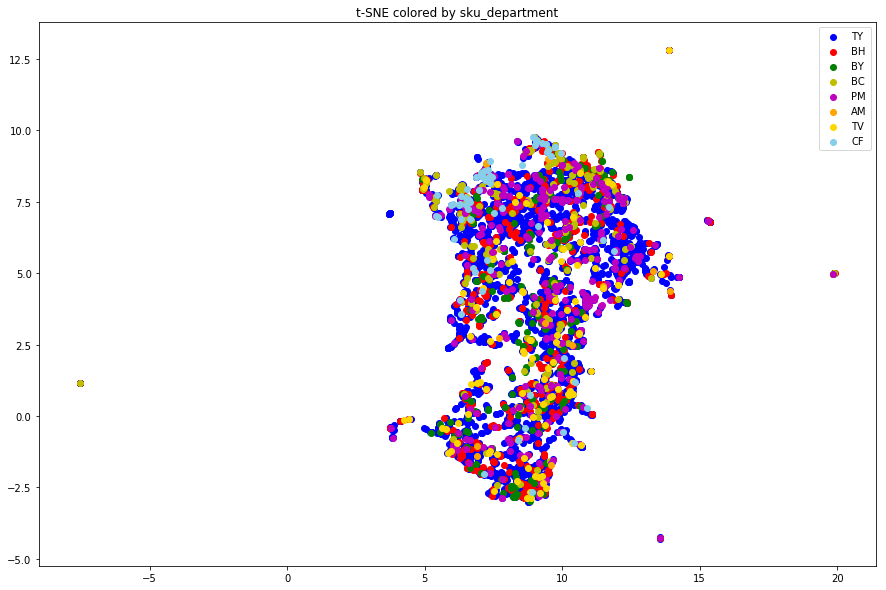

In [38]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

Show distribution of cumulative sales on embedding

In [39]:
sales_df = product_sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']]\
.merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['sales_log'] = np.log10(sales_df['sales'])

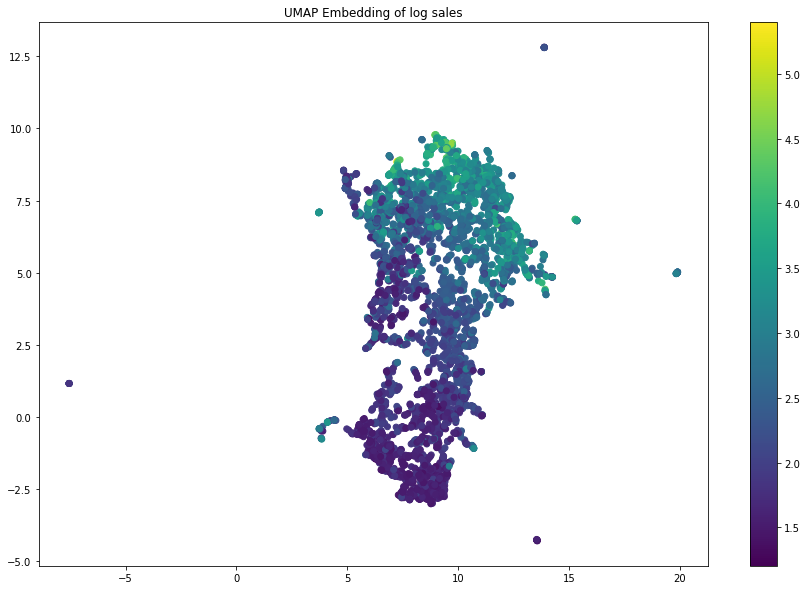

In [40]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('UMAP Embedding of log sales')
plt.show()

# Clustering and cluster analysis

In [8]:
run_cont = ['sales', 'selling_price', 'avg_discount', 'stock_open']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory', 'sku_label']

In [7]:
som_clus = pd.read_csv('som_clusters_nans.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

Cluster sizes:


In [9]:
for i, j in df_dict.items():
    print(i, len(j['sku_key'].unique()))

cluster_2 1422
cluster_4 323
cluster_3 1701
cluster_5 16
cluster_0 1113
cluster_1 3


Clusters on embedding

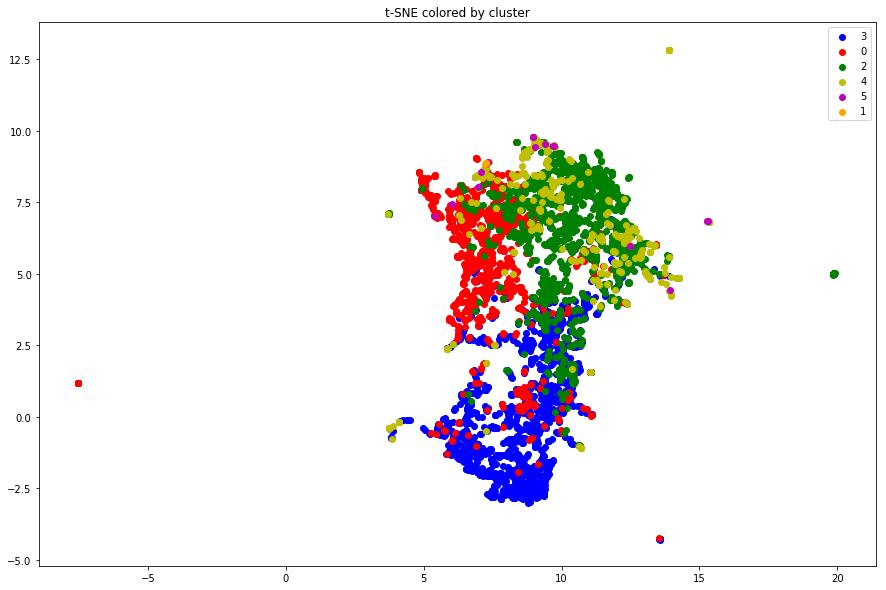

In [41]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, False)

Have a look at the time series for each of the clusters

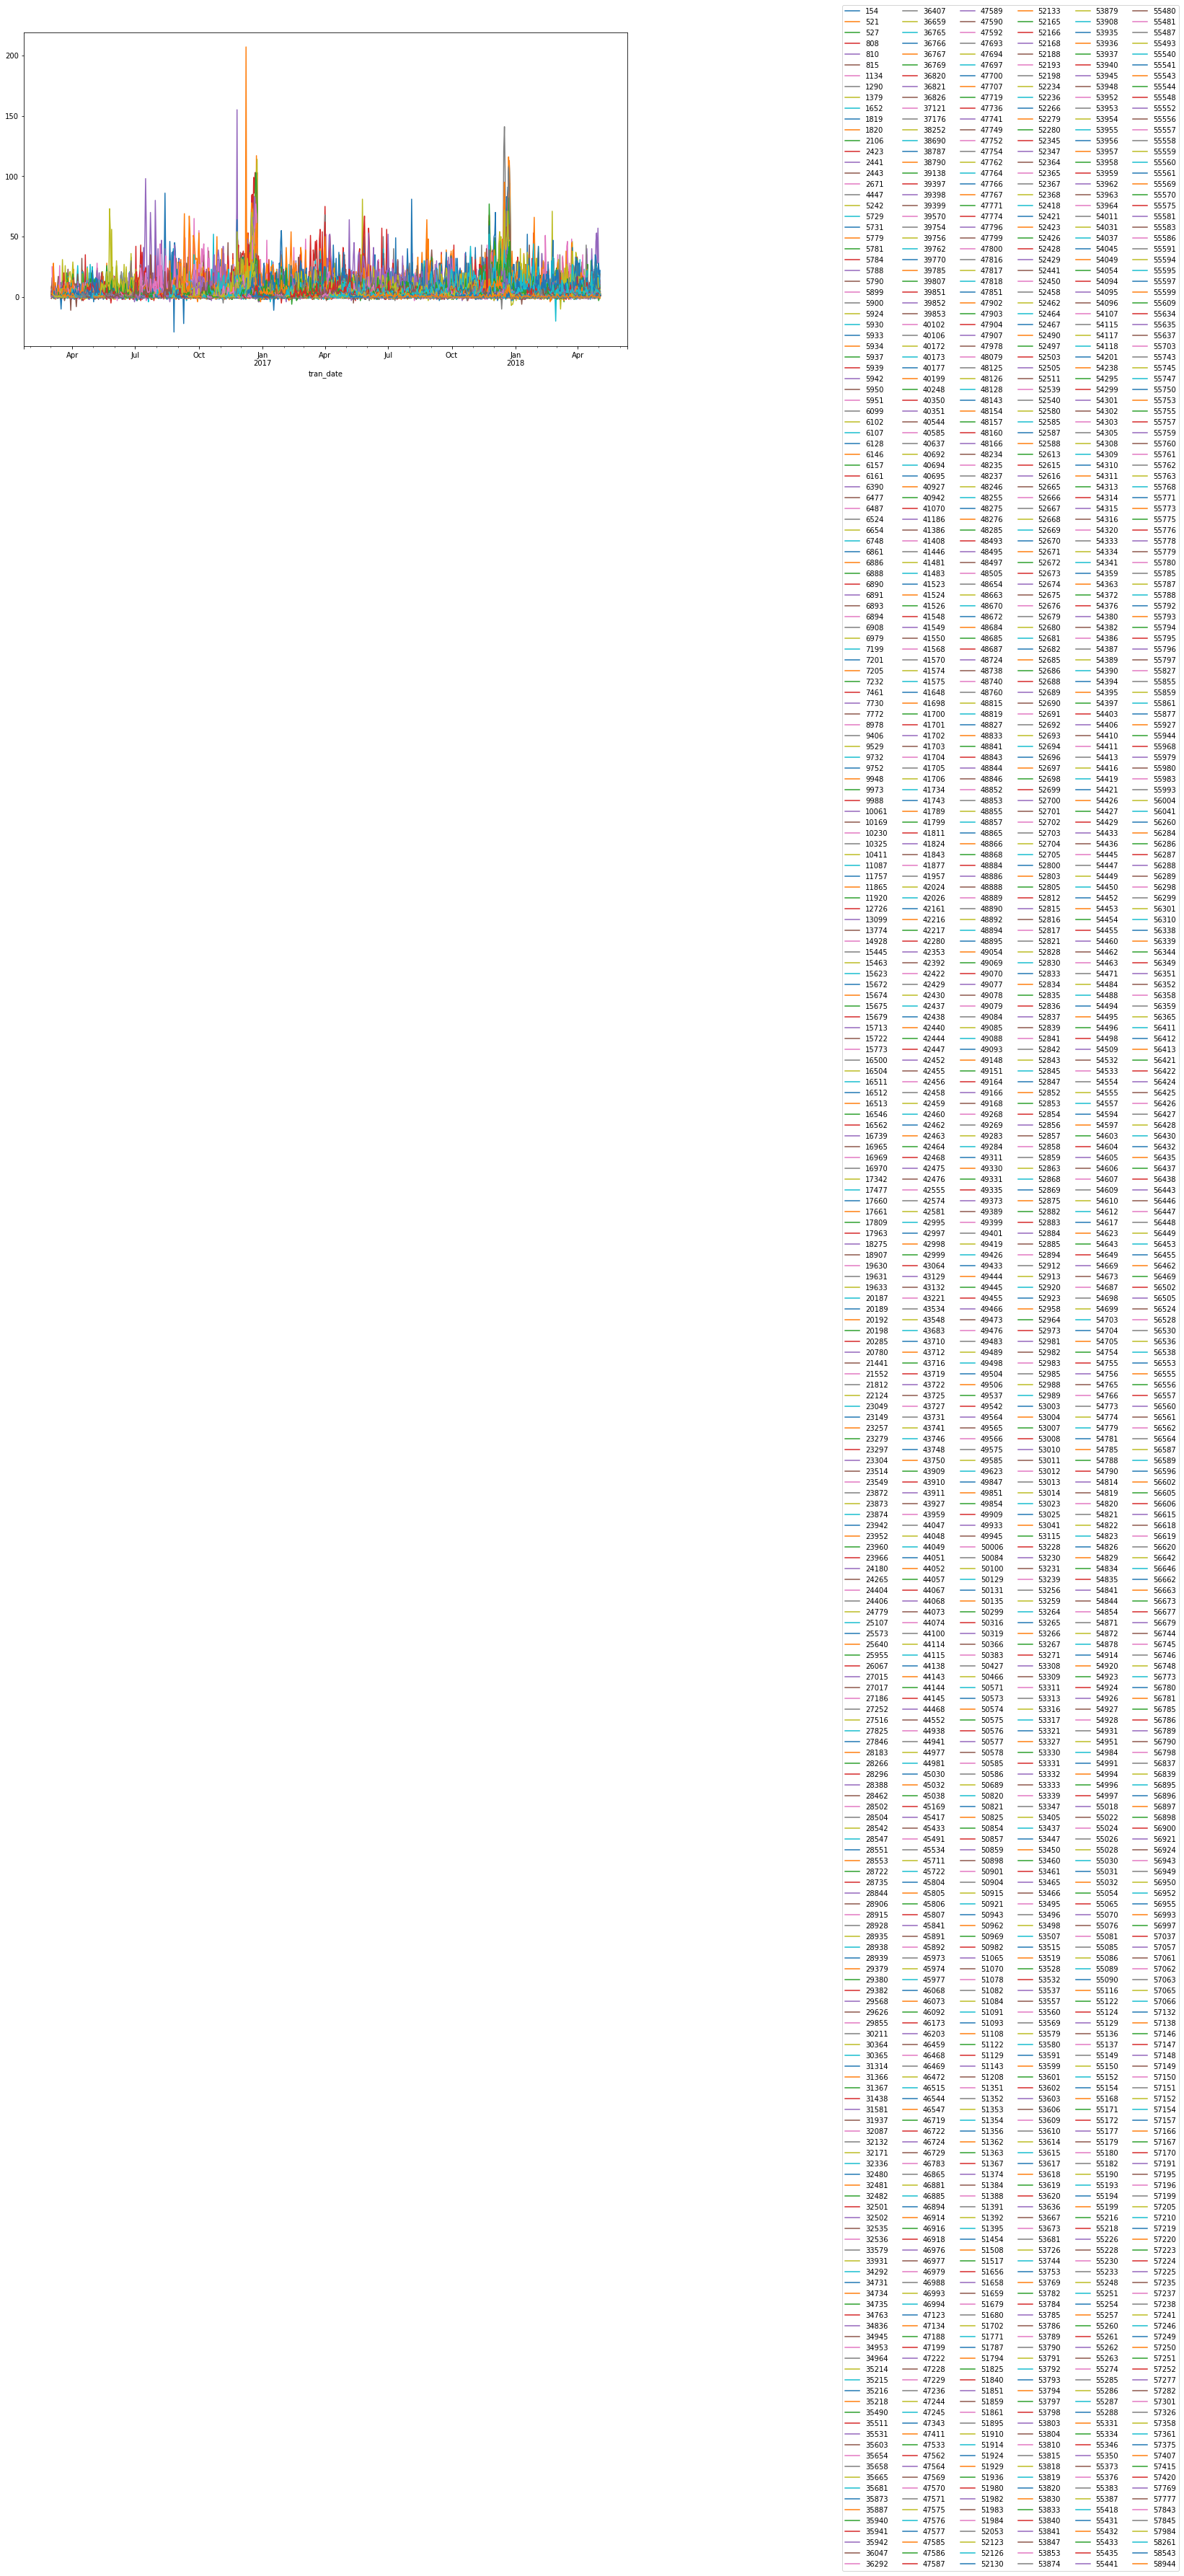

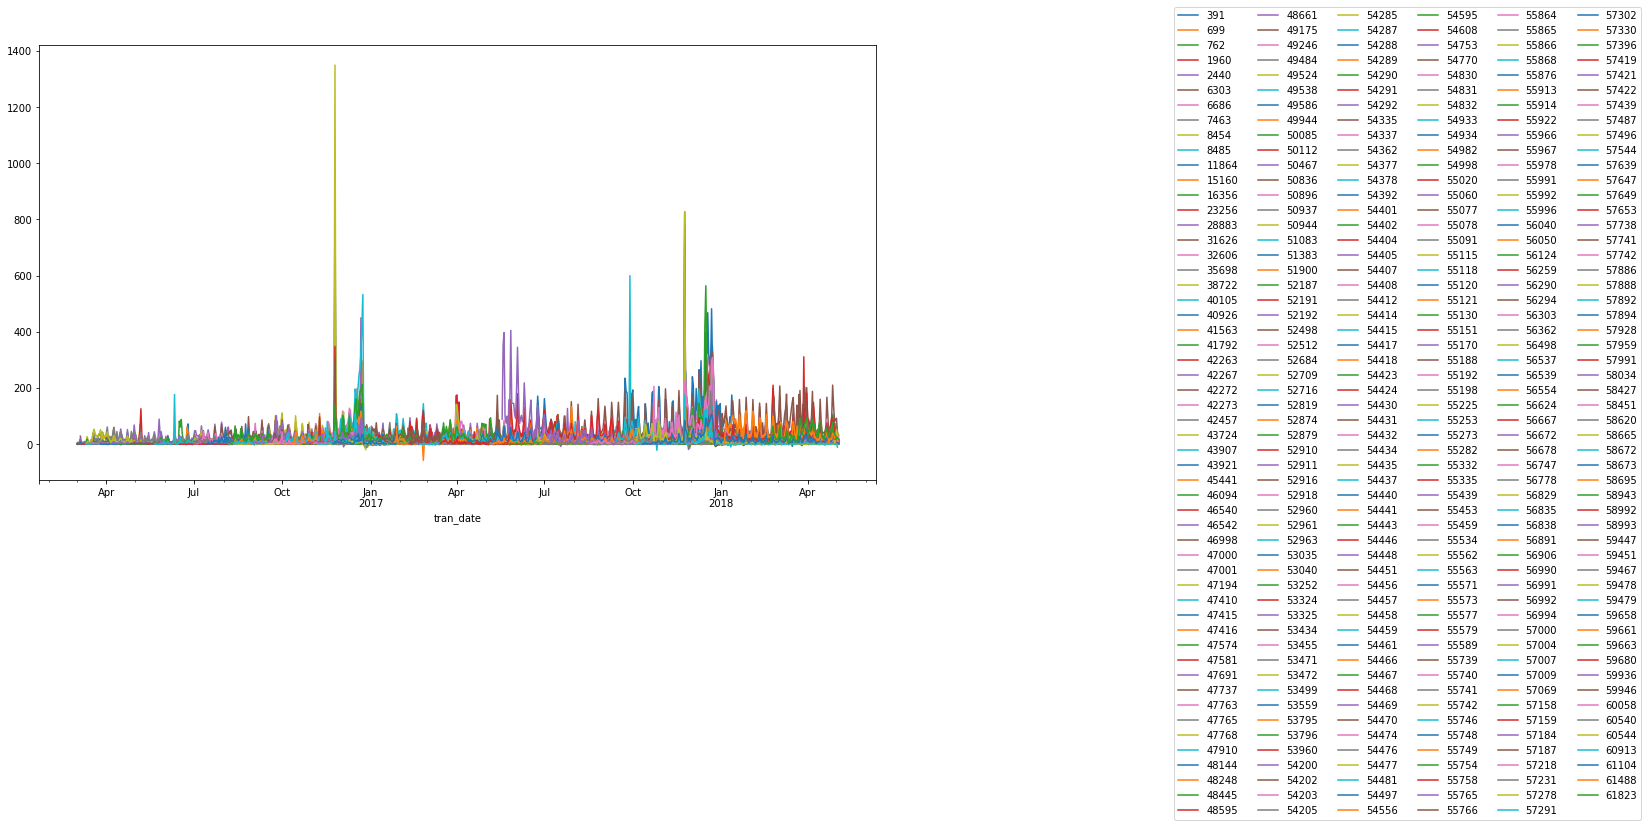

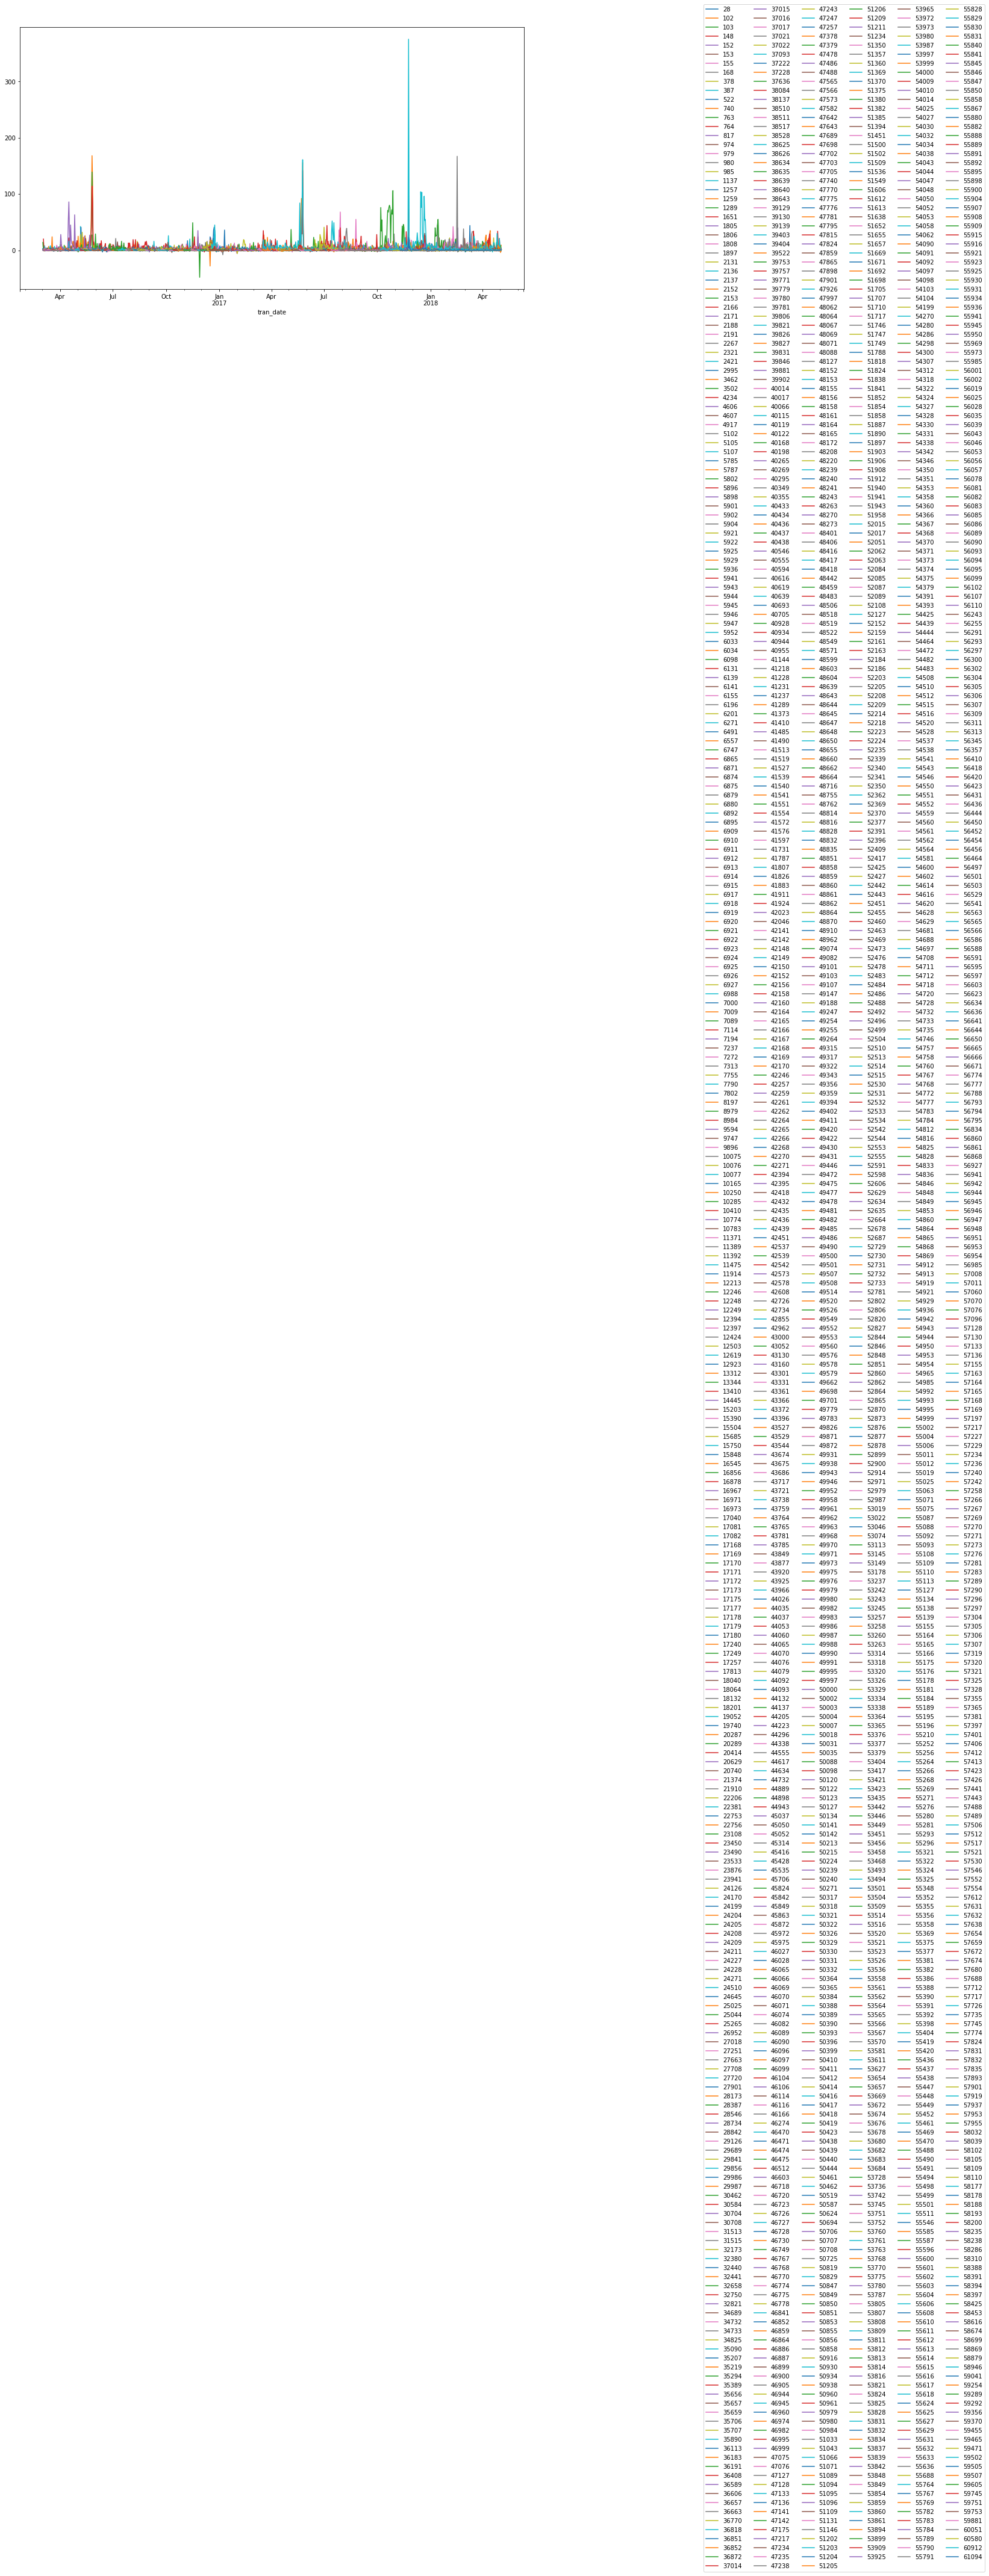

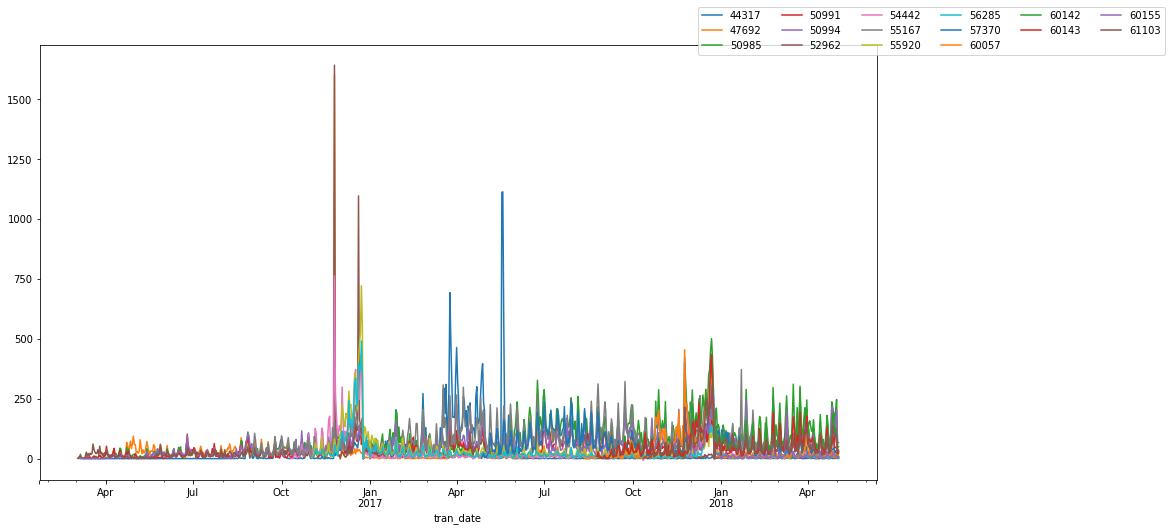

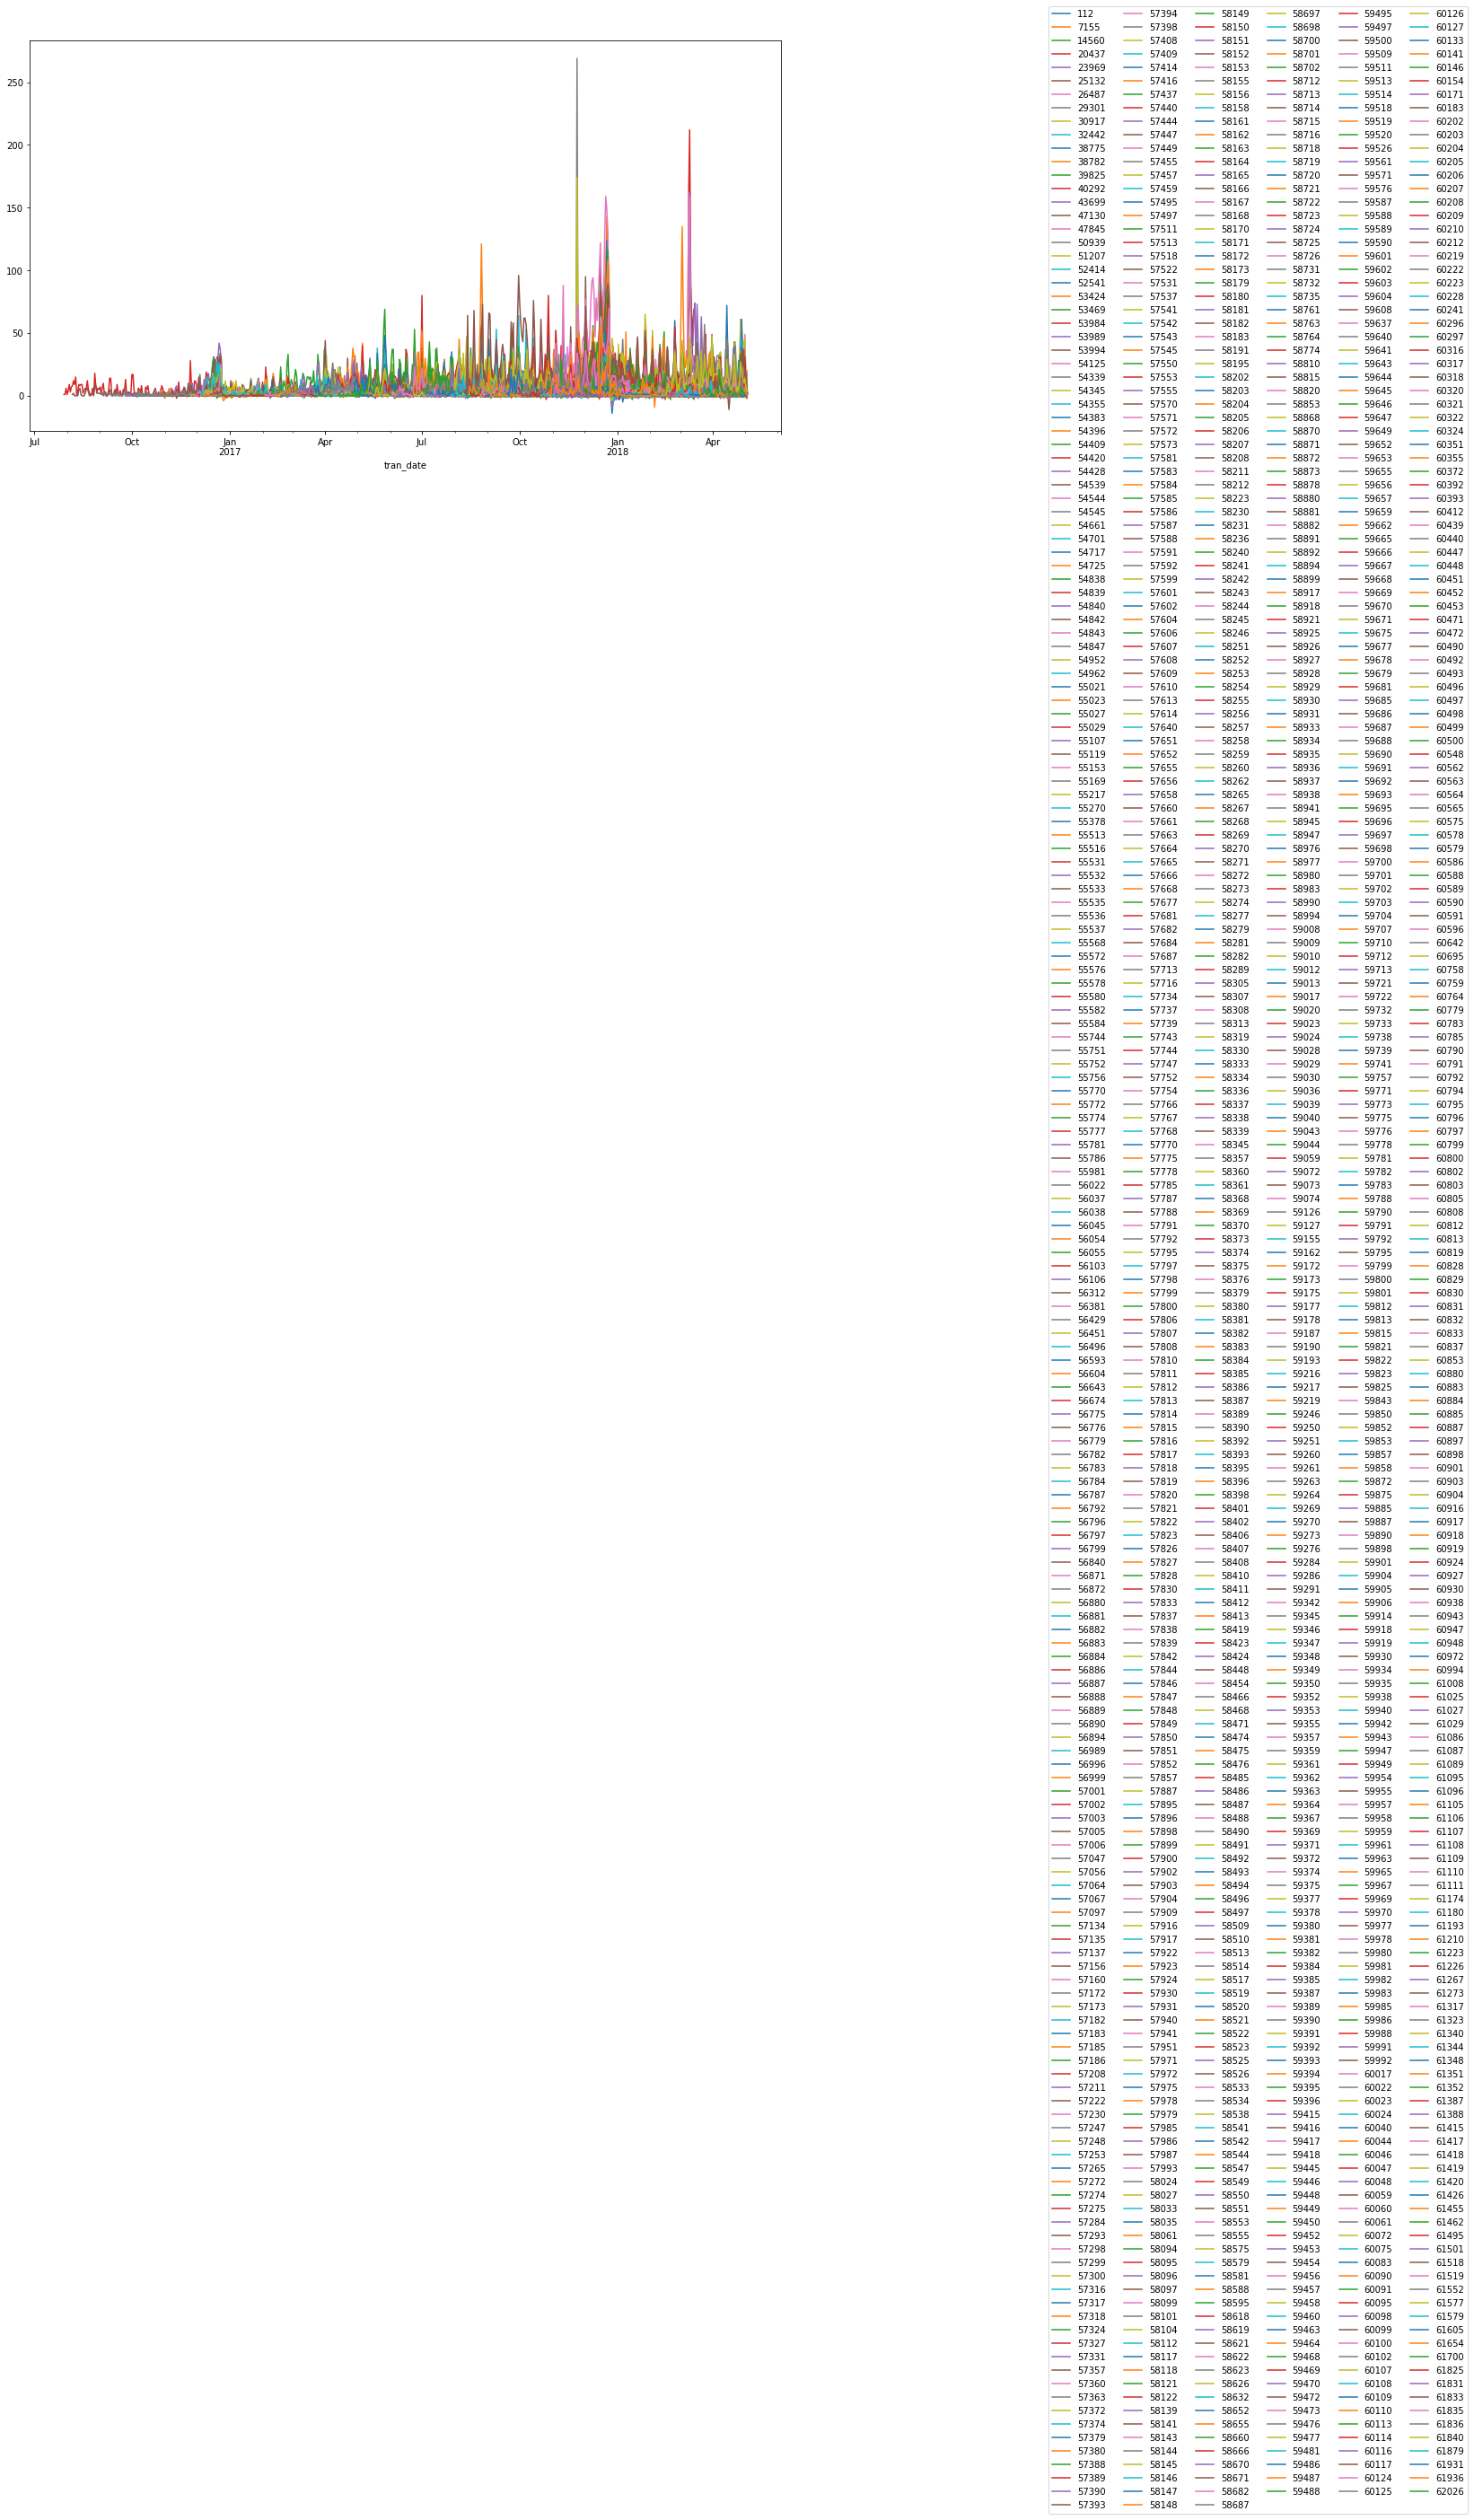

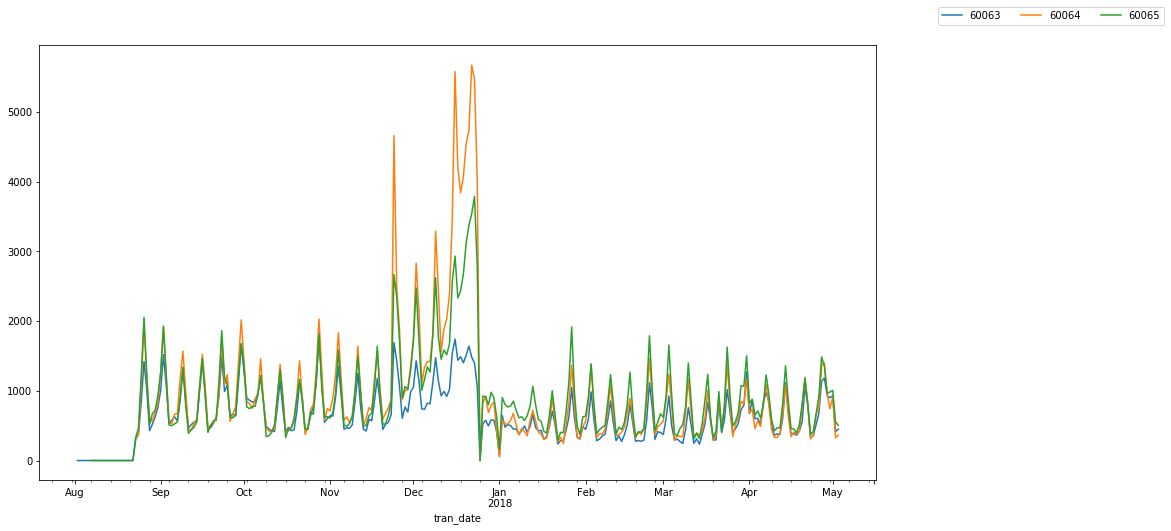

In [11]:
analyze_som.plot_all_timeseries(df_dict)

Have a look at the mean time series for each of the clusters

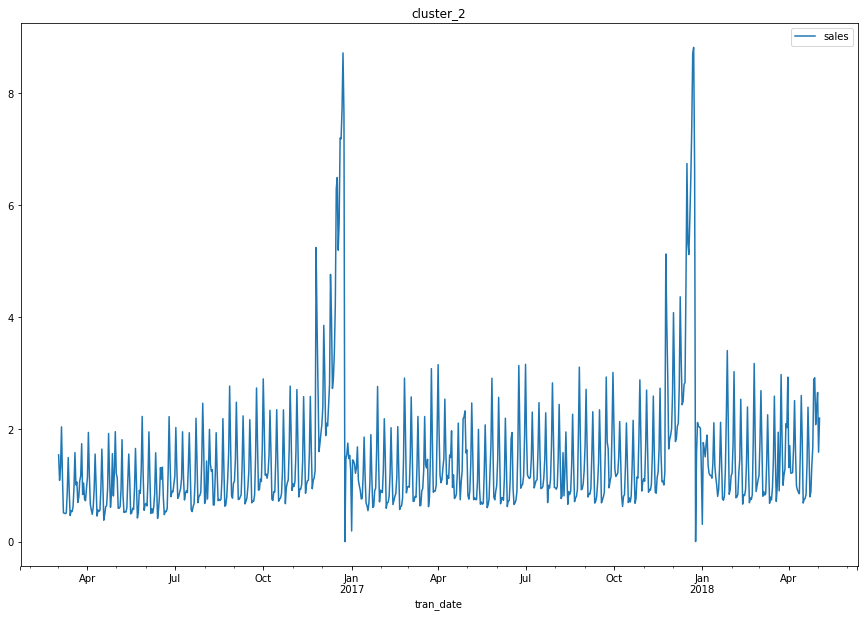

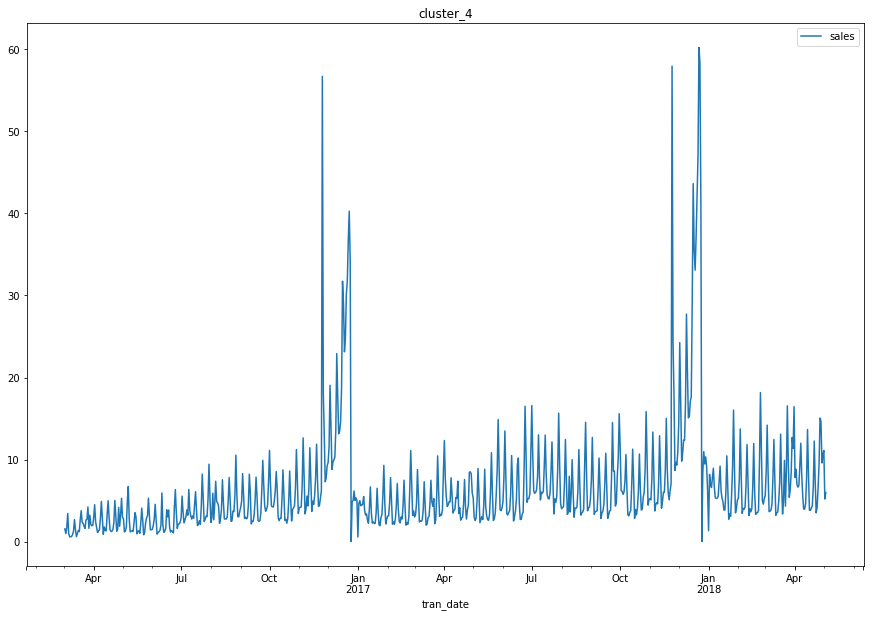

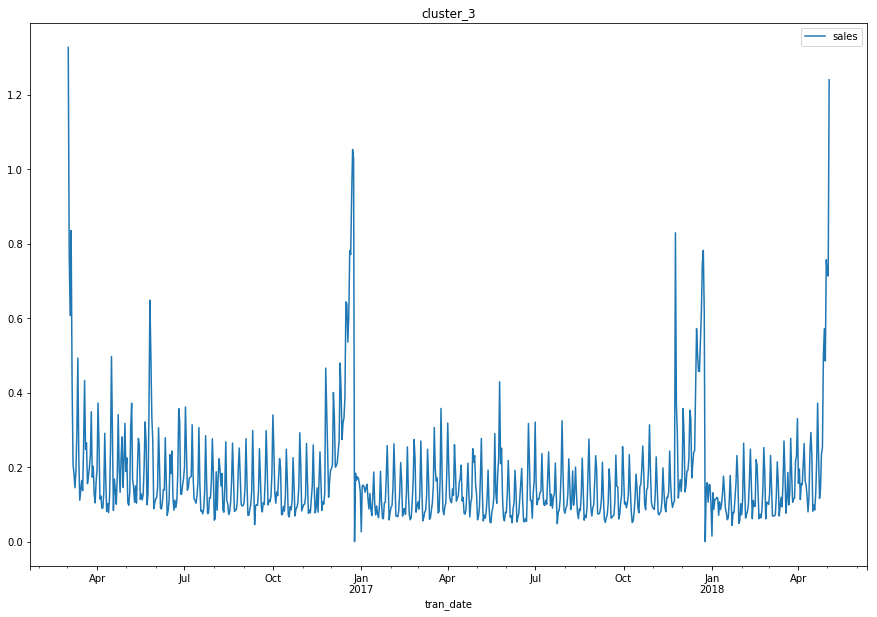

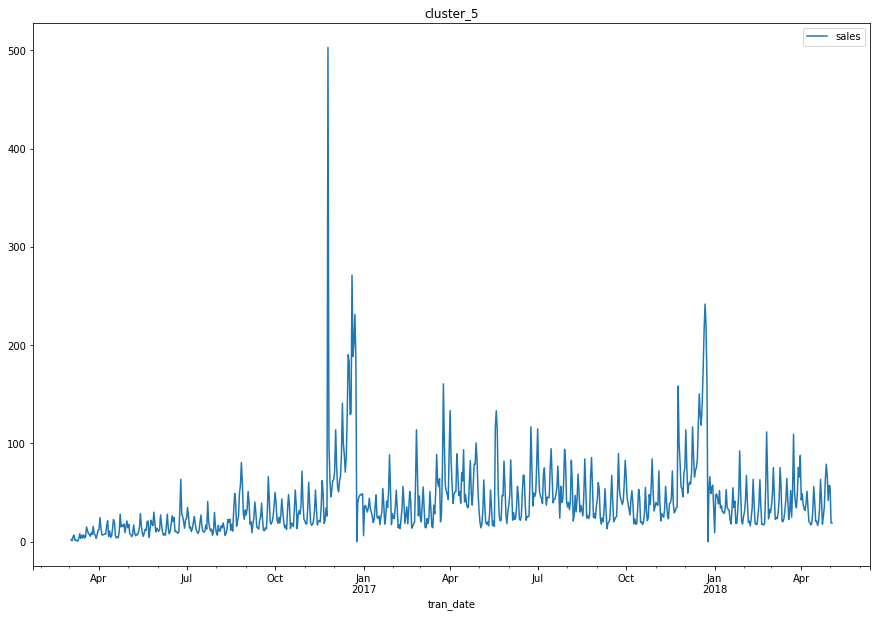

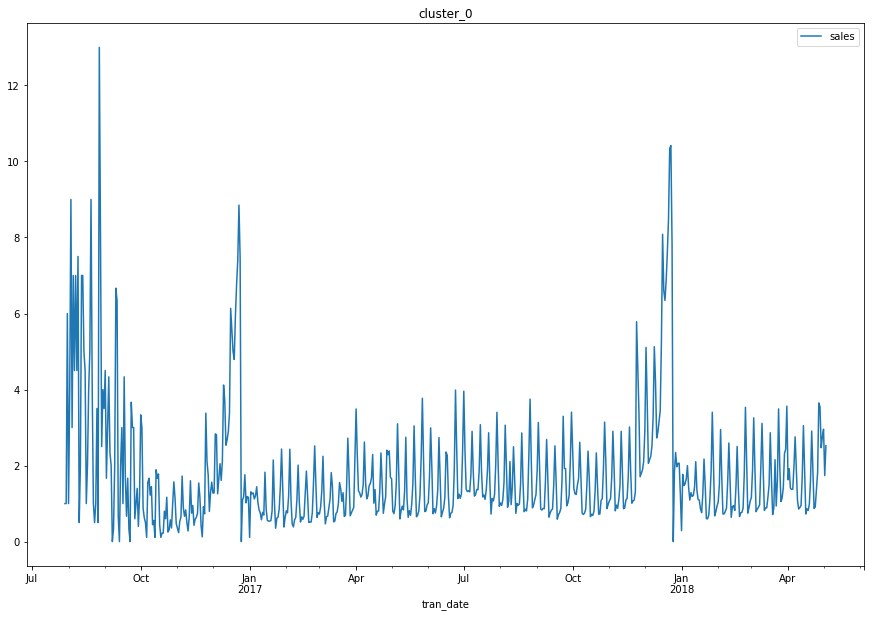

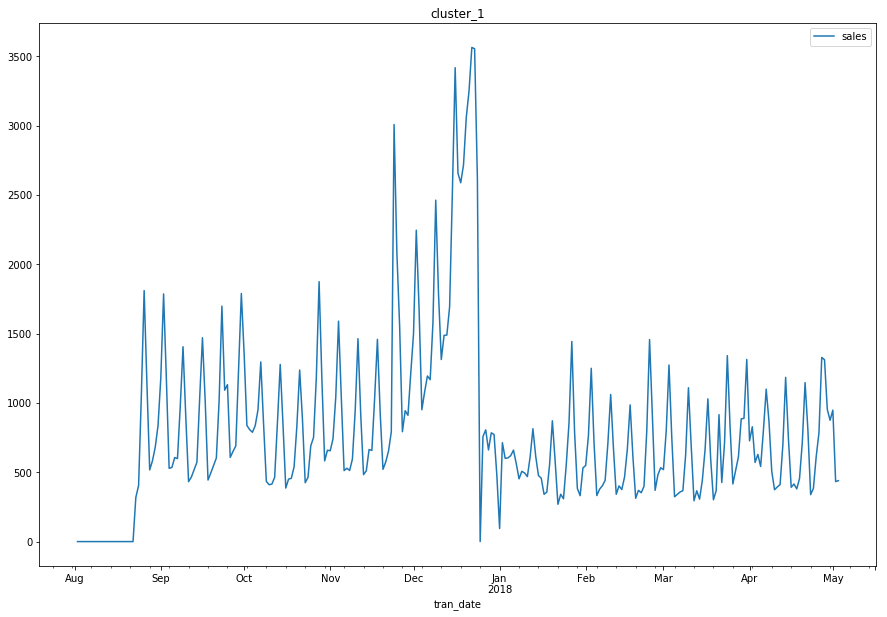

In [12]:
analyze_som.plot_mean_timeseries(df_dict)

Have a look at the median time series for each of the clusters

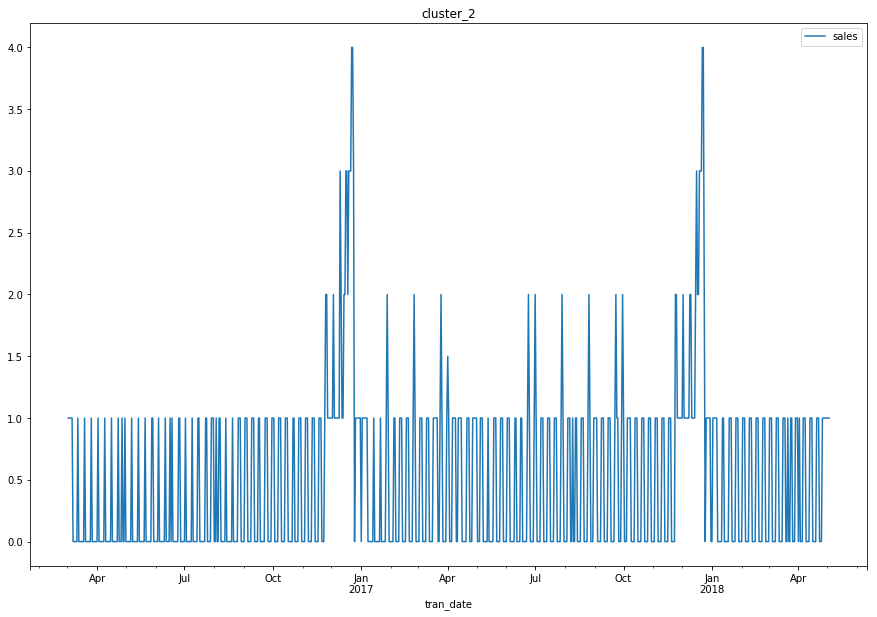

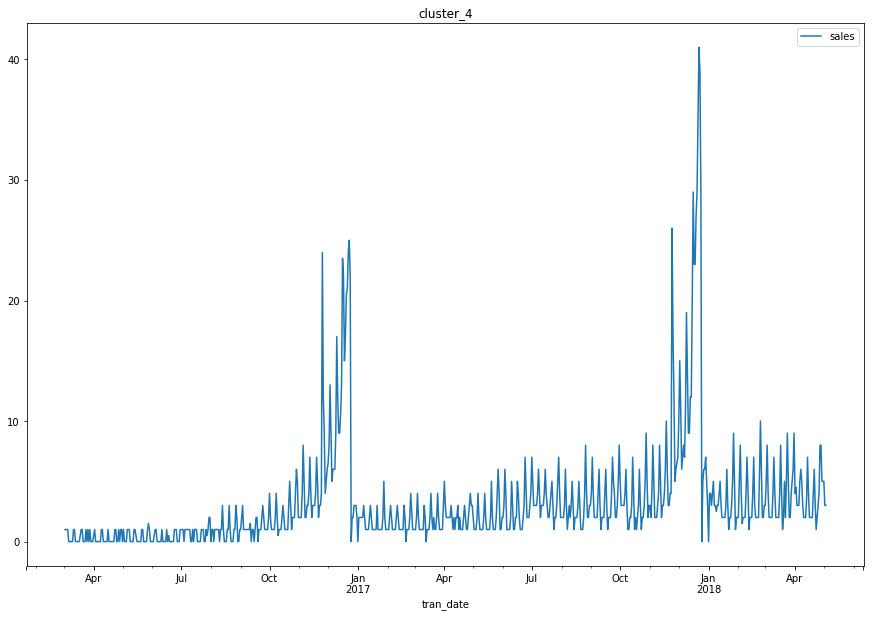

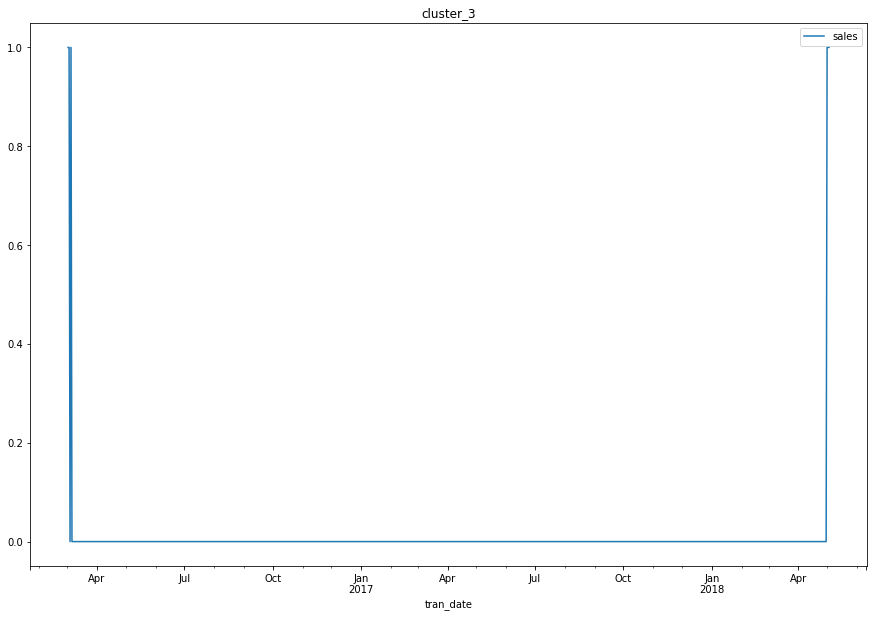

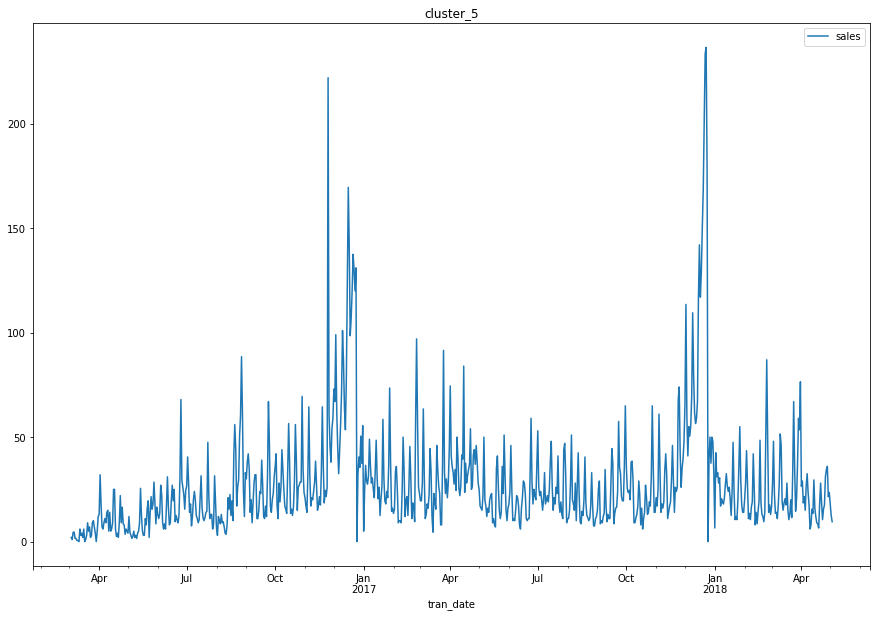

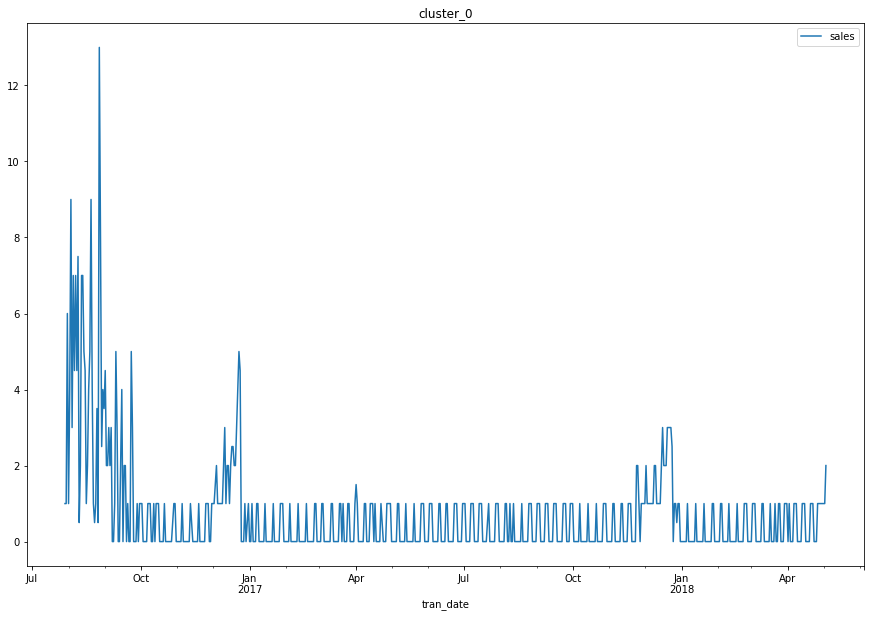

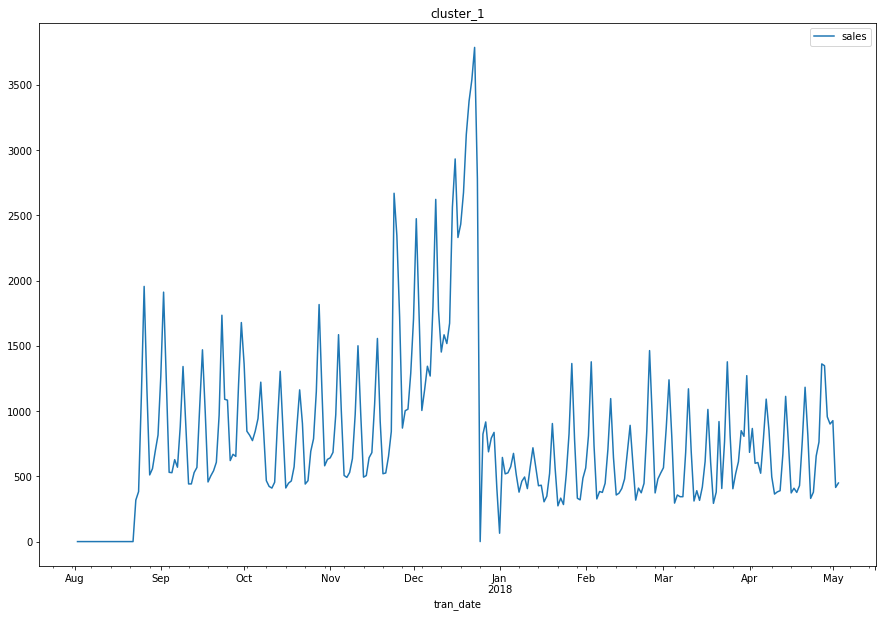

In [13]:
analyze_som.plot_median_timeseries(df_dict)

Have a look at the smoothed mean for each of the clusters

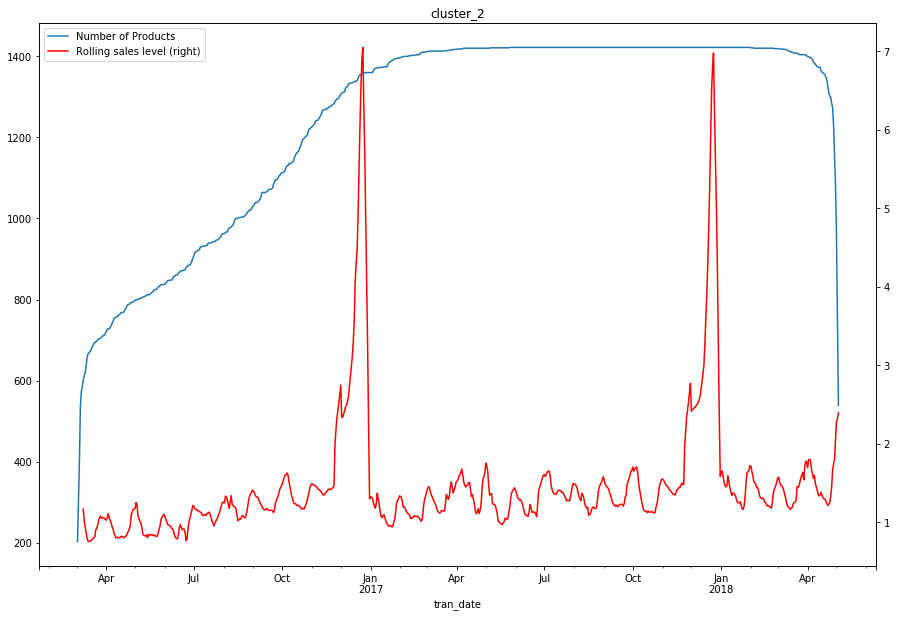

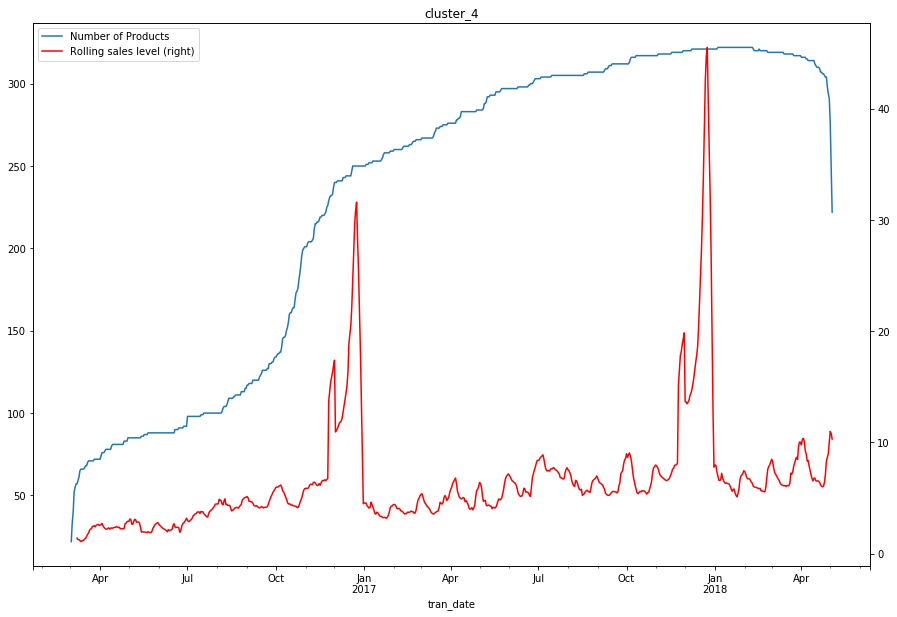

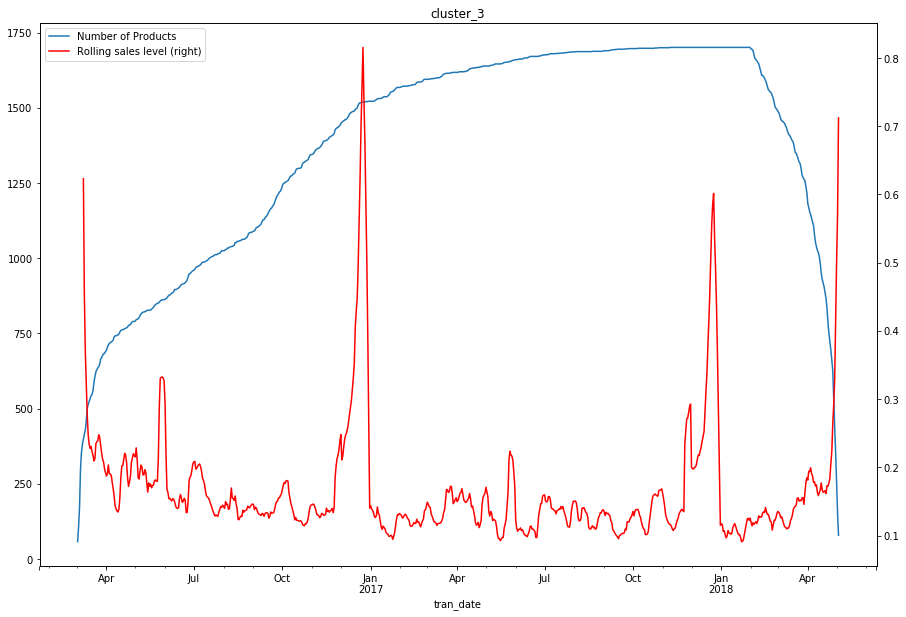

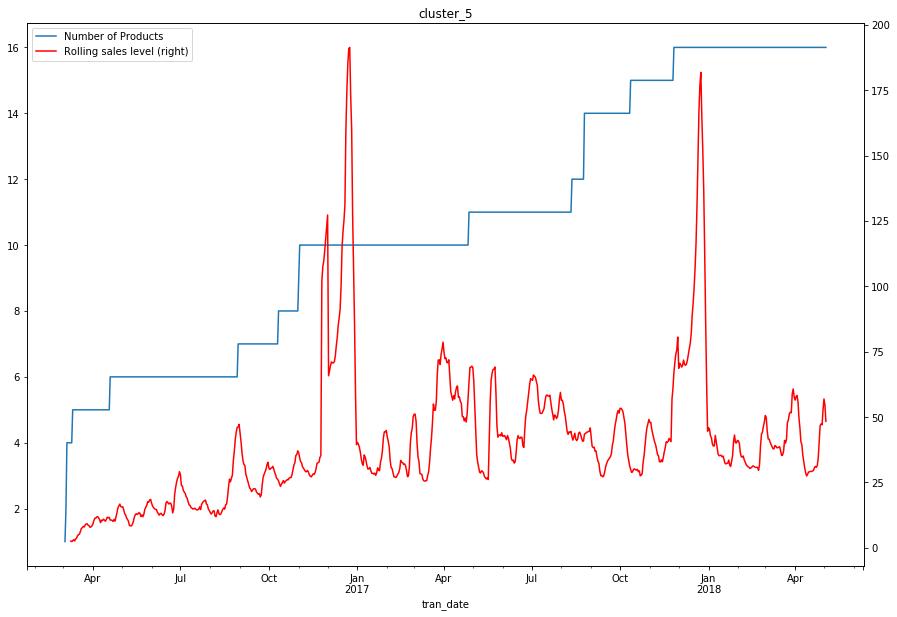

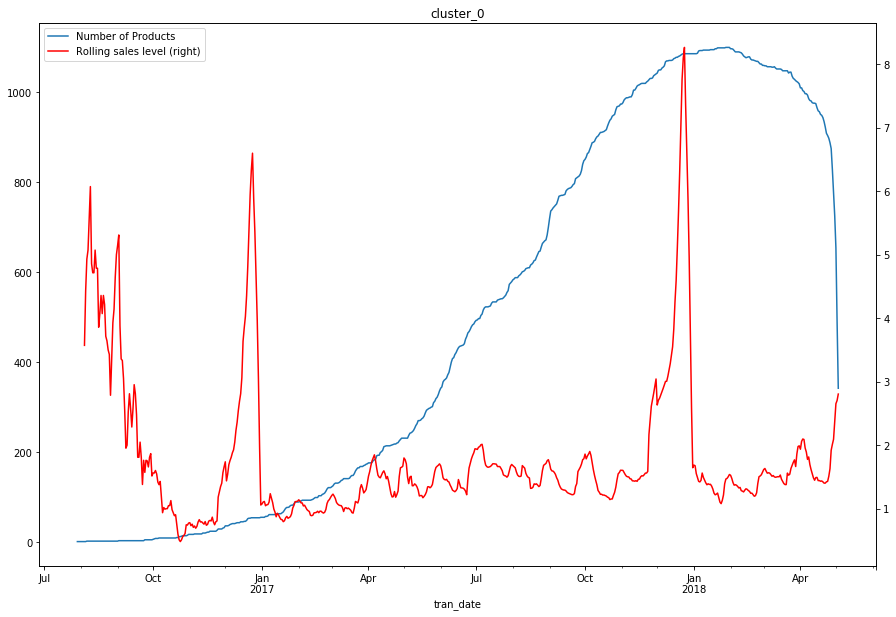

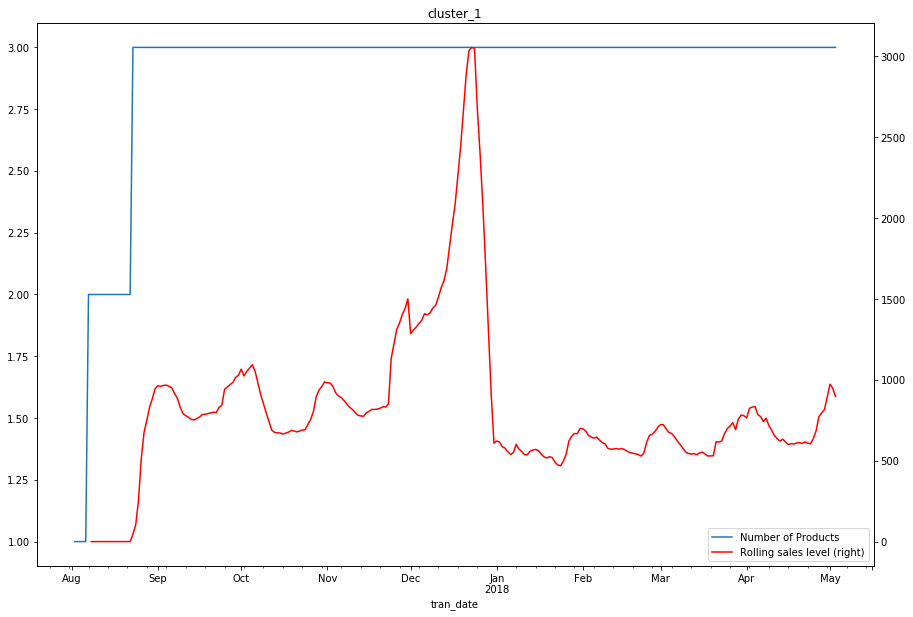

In [49]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'sales', plot_second=True,  period=7)

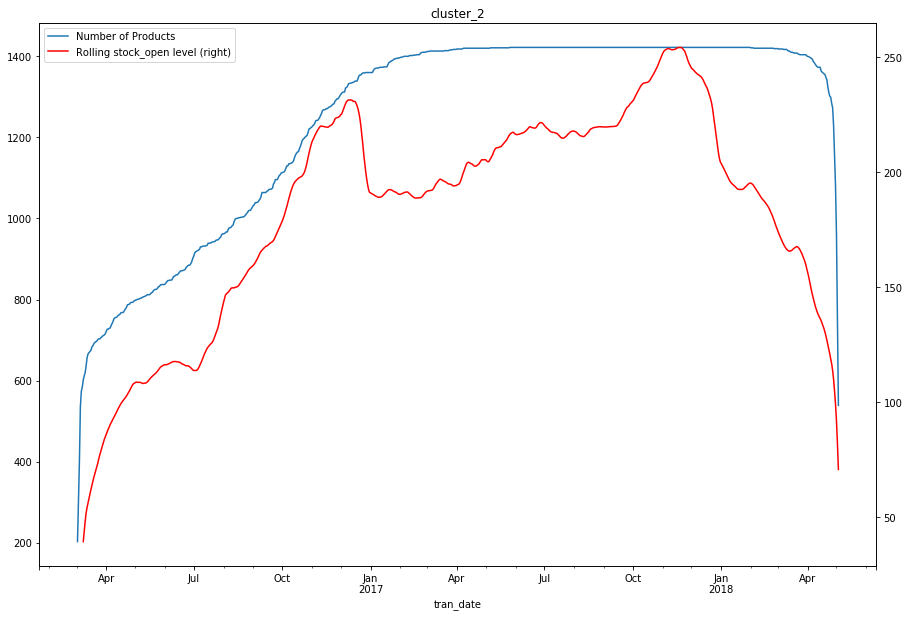

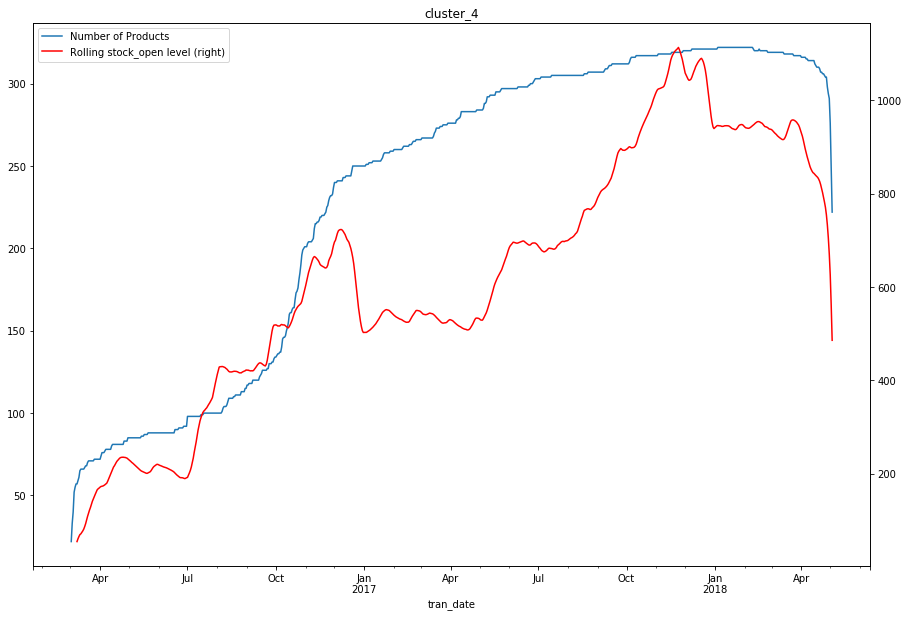

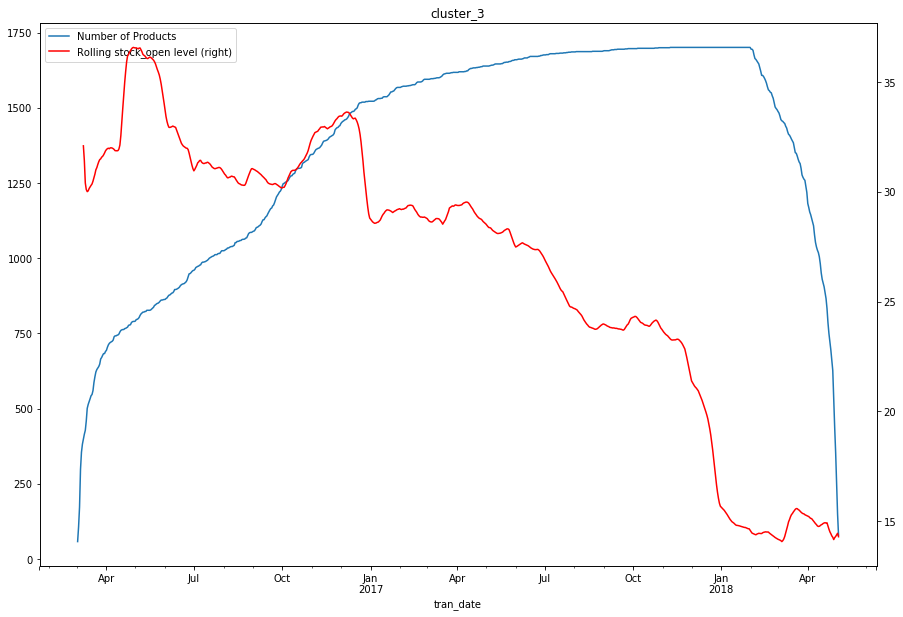

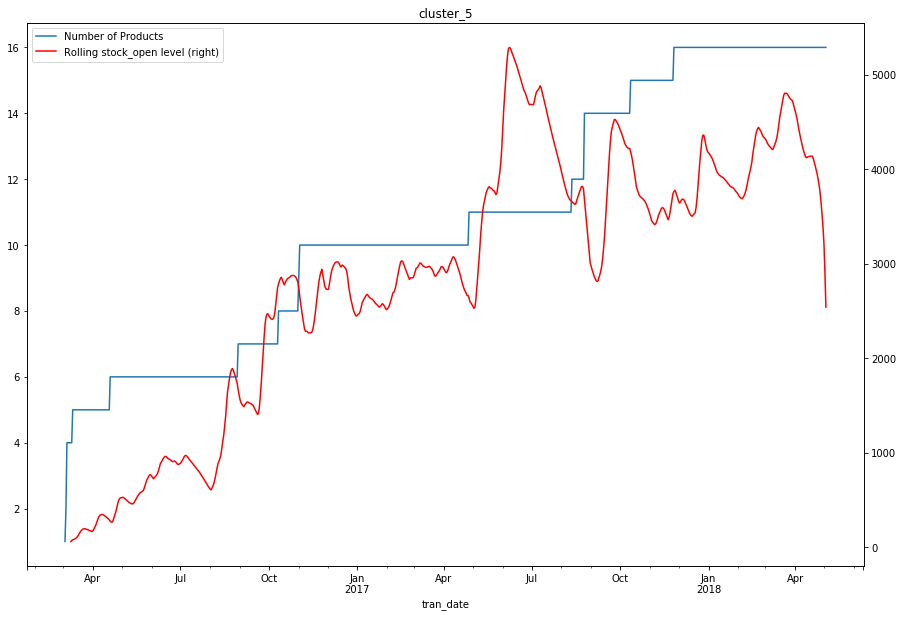

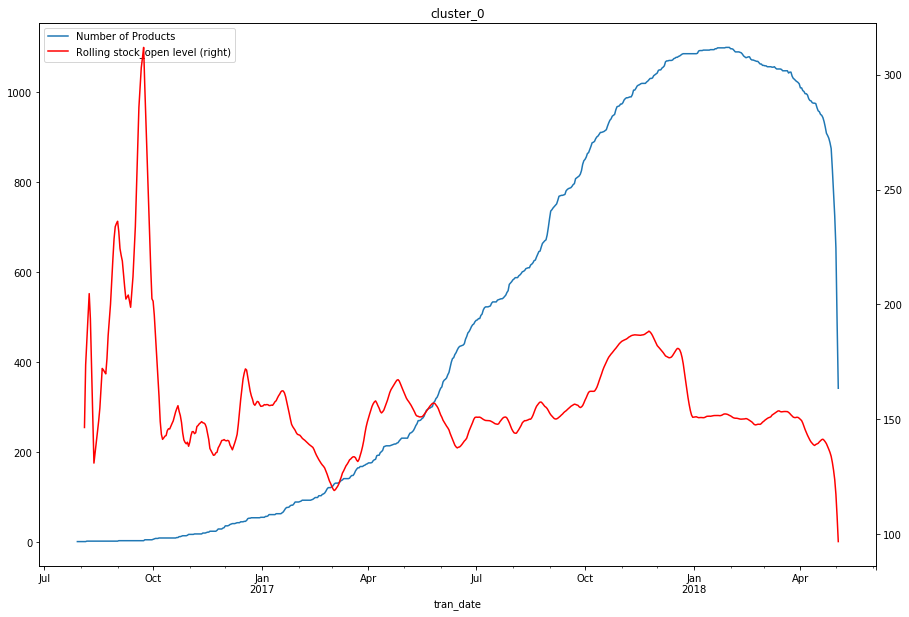

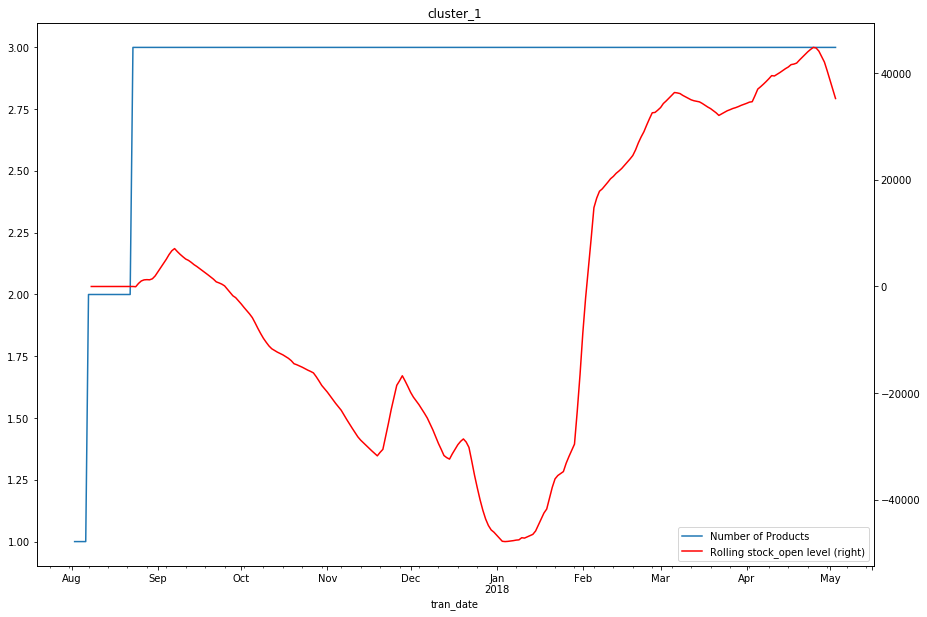

In [14]:
analyze_som.plot_rolling_mean_timeseries(df_dict, 'stock_open', plot_second=True,  period=7)

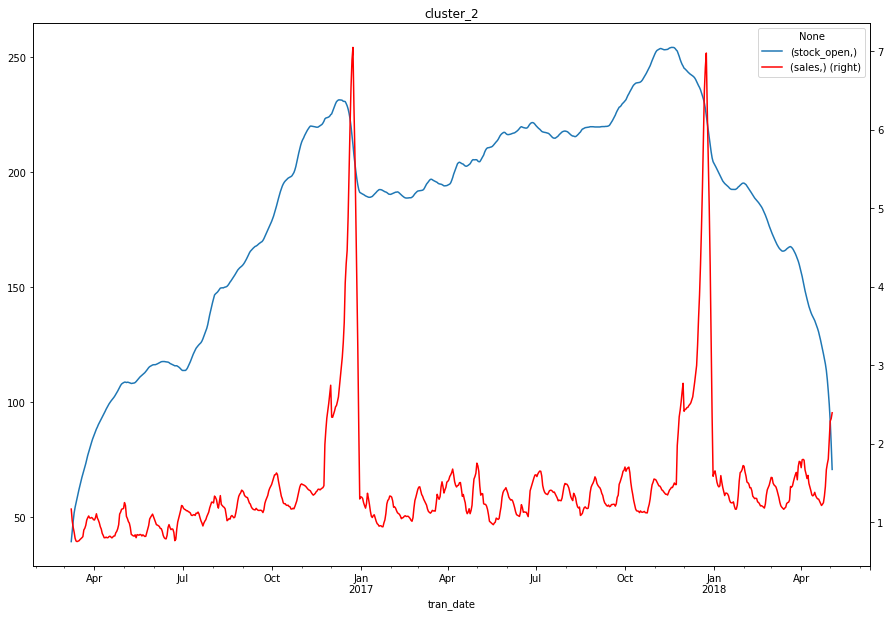

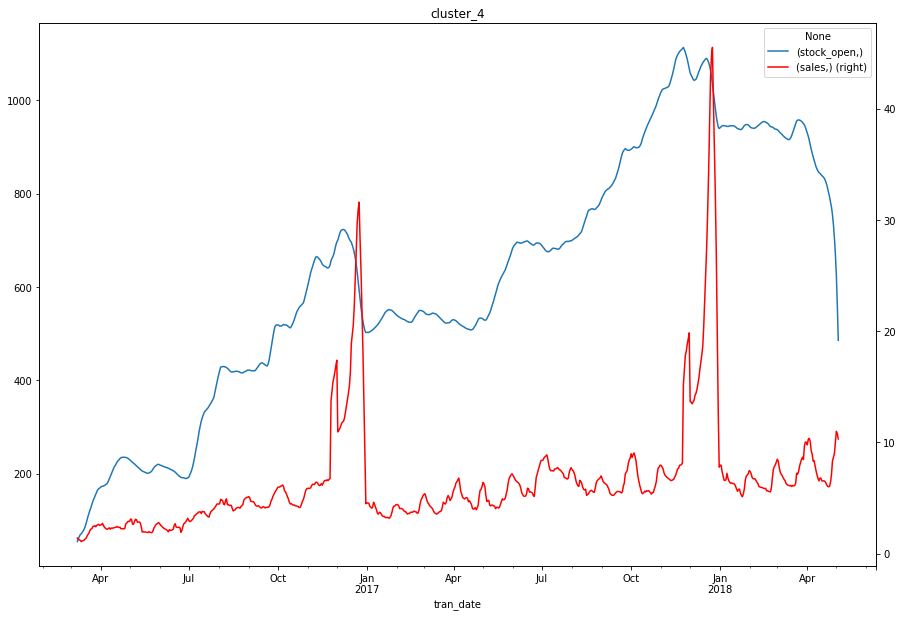

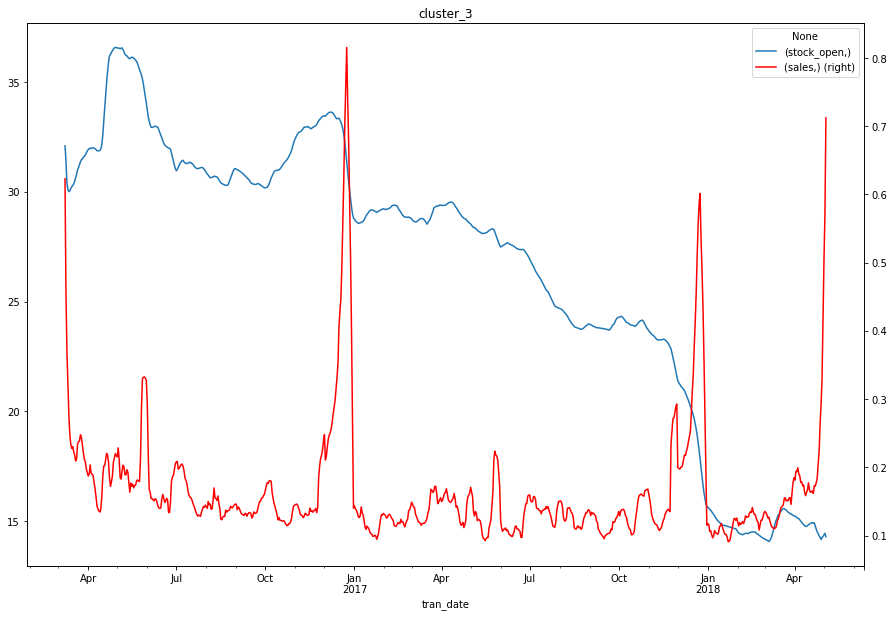

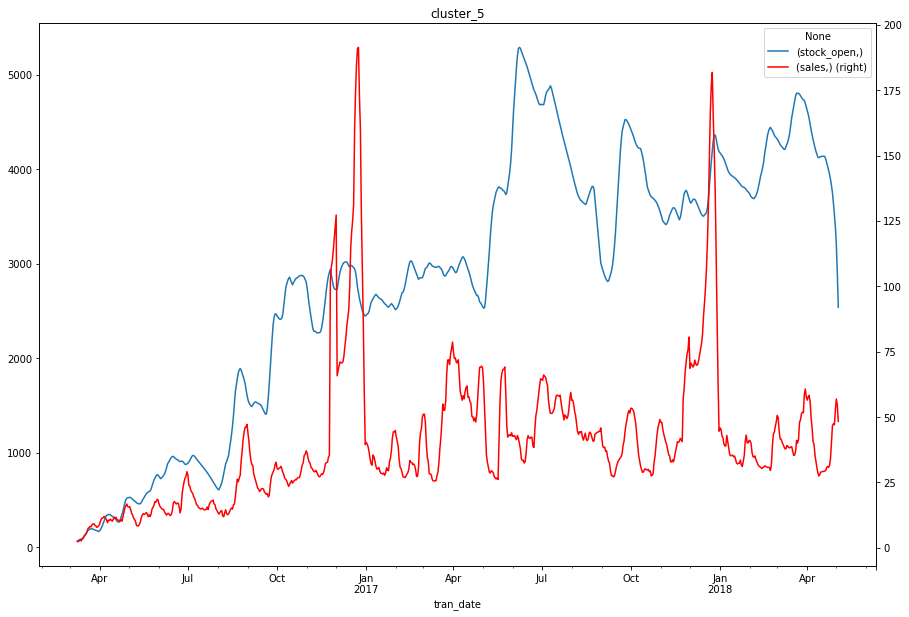

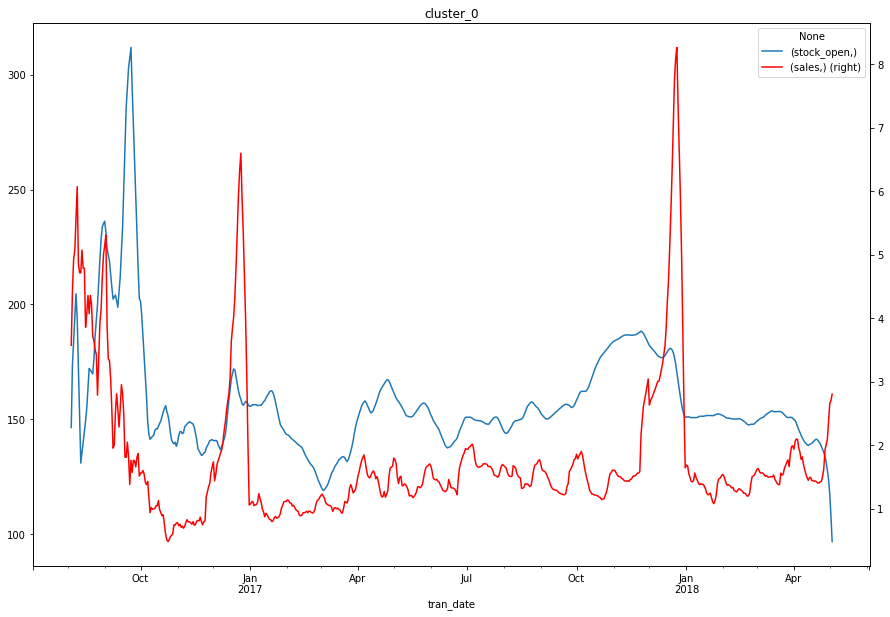

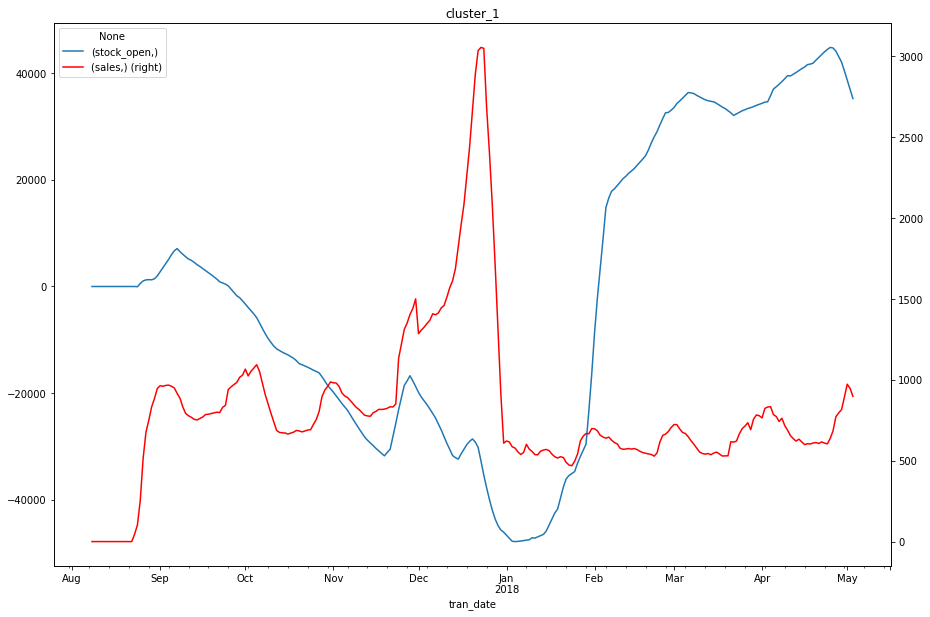

In [15]:
analyze_som.plot_double_rolling_mean(df_dict, ['stock_open', 'sales'], plot_second=True,  period=7)

In [16]:
df_dict['cluster_0'].groupby('tran_date').count()

sku_key  cluster  sales  selling_price  avg_discount  stock_open  \
tran_date                                                                      
2016-07-29        1        1      1              1             1           1   
2016-07-30        1        1      1              1             1           1   
2016-07-31        1        1      1              1             1           1   
2016-08-01        1        1      1              1             1           1   
2016-08-02        1        1      1              1             1           1   
2016-08-03        1        1      1              1             1           1   
2016-08-04        1        1      1              1             1           1   
2016-08-05        1        1      1              1             1           1   
2016-08-06        2        2      2              2             2           2   
2016-08-07        2        2      2              2             2           2   
2016-08-08        2        2      2              2             2           2   
2016-08-09        2        2      2              2             2           2   
2016-08-10        2        2      2              2             2           2   
2016-08-11        2        2      2              2             2           2   
2016-08-12        2        2      2              2             2           2   
2016-08-13        2        2      2              2             2           2   
2016-08-14        2        2      2              2             2           2   
2016-08-15        2        2      2              2             2           2   
2016-08-16        2        2      2              2             2           2   
2016-08-17        2        2      2              2             2           2   
2016-08-18        2        2      2              2             2           2   
2016-08-19        2        2      2              2             2           2   
2016-08-20        2        2      2              2             2           2   
2016-08-21        2        2      2              2             2           2   
2016-08-22        2        2      2              2             2           2   
2016-08-23        2        2      2              2             2           2   
2016-08-24        2        2      2              2             2           2   
2016-08-25        2        2      2              2             2           2   
2016-08-26        2        2      2              2             2           2   
2016-08-27        2        2      2              2             2           2   
...             ...      ...    ...            ...           ...         ...   
2018-04-04     1002     1002   1002           1002          1002        1002   
2018-04-05      997      997    997            997           997         997   
2018-04-06      997      997    997            997           997         997   
2018-04-07      994      994    994            994           994         994   
2018-04-08      986      986    986            986           986         986   
2018-04-09      982      982    982            982           982         982   
2018-04-10      981      981    981            981           981         981   
2018-04-11      977      977    977            977           977         977   
2018-04-12      976      976    976            976           976         976   
2018-04-13      976      976    976            976           976         976   
2018-04-14      975      975    975            975           975         975   
2018-04-15      966      966    966            966           966         966   
2018-04-16      959      959    959            959           959         959   
2018-04-17      957      957    957            957           957         957   
2018-04-18      951      951    951            951           951         951   
2018-04-19      949      949    949            949           949         949   
2018-04-20      944      944    944            944           944         944   
2018-04-21  

Have a look at the amount of time series which start within the specified period or which started priod to the start of the period

cluster_2, there are 1422 skus and 1506407 sales.


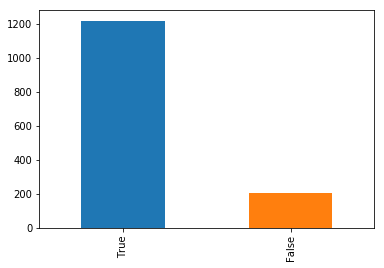

cluster_4, there are 323 skus and 1376825 sales.


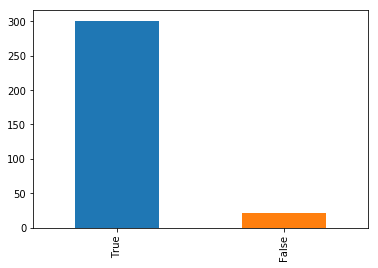

cluster_3, there are 1701 skus and 176410 sales.


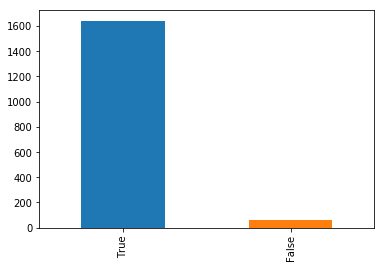

cluster_5, there are 16 skus and 373702 sales.


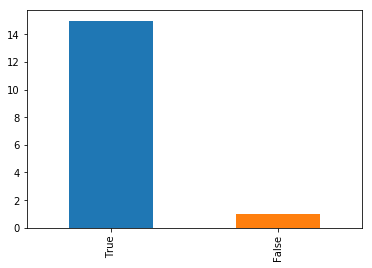

cluster_0, there are 1113 skus and 582625 sales.


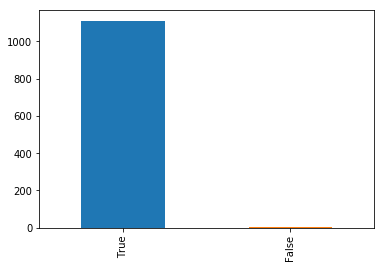

cluster_1, there are 3 skus and 667649 sales.


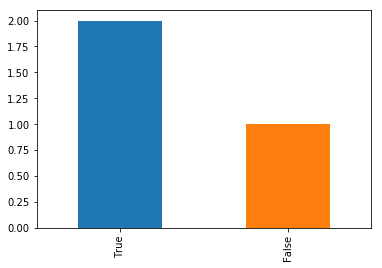

In [17]:
for i, j in df_dict.items():
    print('{}, there are {} skus and {} sales.'.format(i, len(j['sku_key'].unique()), sum(j['sales'])))
    pivot_t = pd.pivot_table(j, index='sku_key', columns='tran_date', values='sales')
    pivot_t['nan'] = pivot_t.iloc[:,0].apply(np.isnan)
    pivot_t['nan'].value_counts().plot(kind='bar')
    plt.show()

Have a look at the distribution of the continuous variables for each cluster

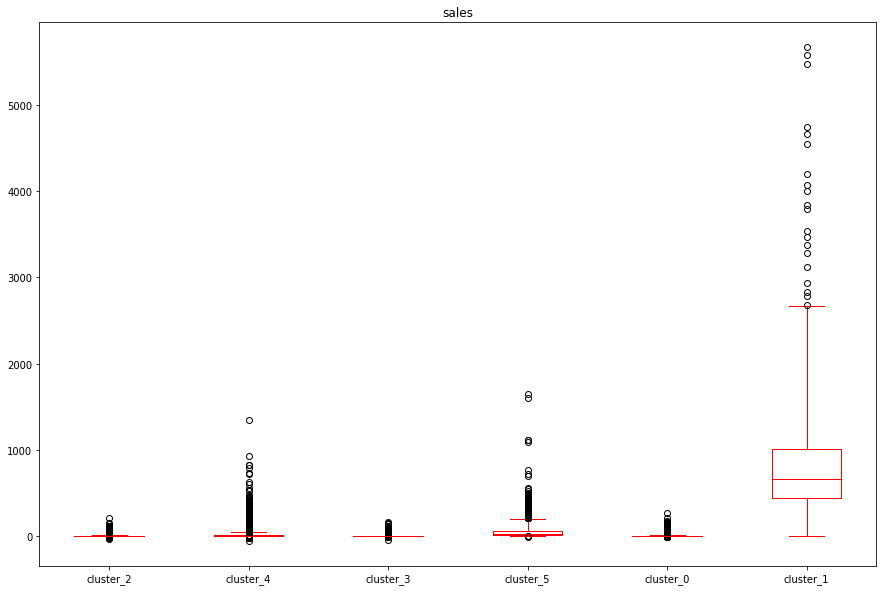

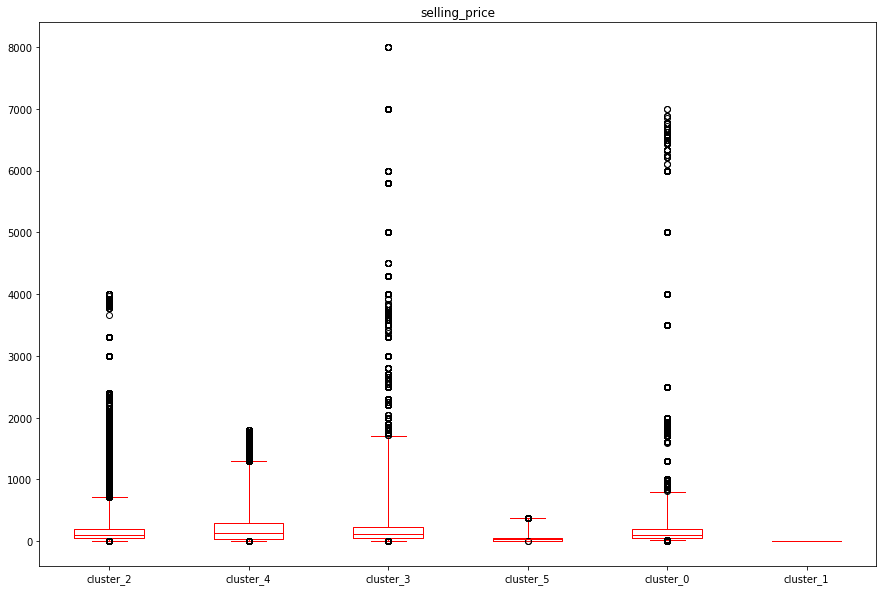

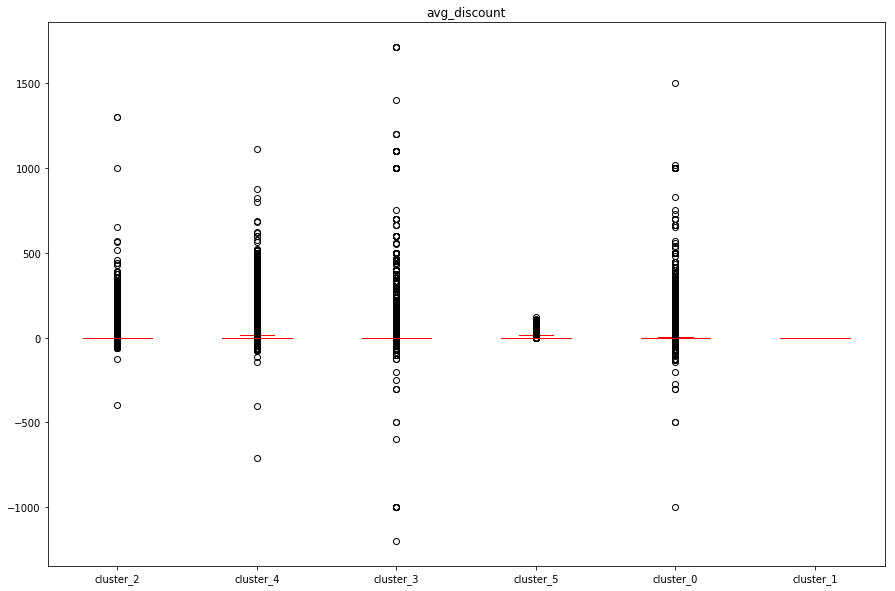

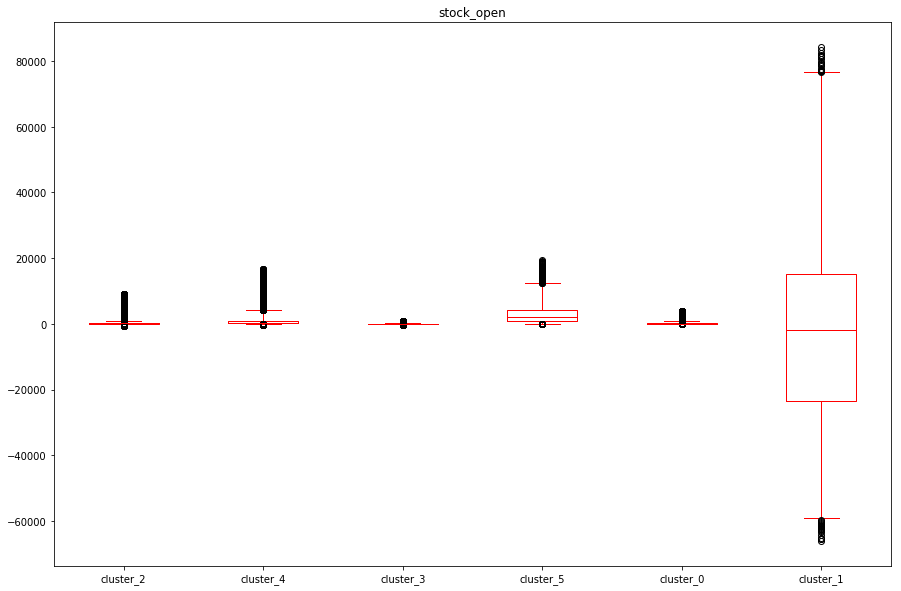

In [19]:
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
#OPTIONAL BELOW
#analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
#analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)

Have a look at the number of returns per cluster and relative percentage

cluster_2 had 987403 sale events
cluster_4 had 185372 sale events
cluster_3 had 1087966 sale events
cluster_5 had 8475 sale events
cluster_0 had 317059 sale events
cluster_1 had 799 sale events


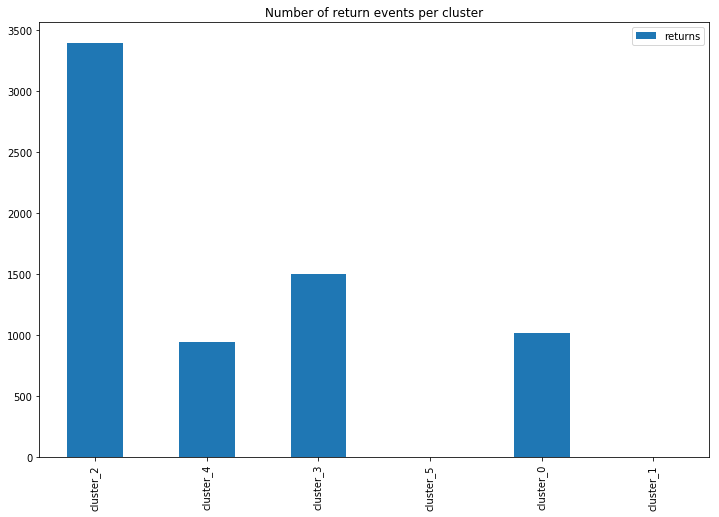

In [18]:
listy = {}
for a, i in df_dict.items():
    print('{} had {} sale events'.format(a, len(i['sales'])))
    x = i[i['sales'] < 0]['sales'].count()
    listy[a] = x
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Number of return events per cluster')
plt.show()

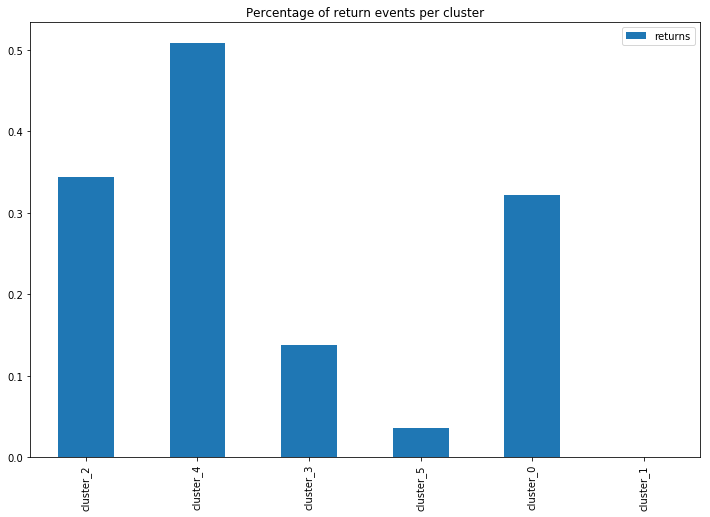

In [20]:
listy = {}
for a, i in df_dict.items():
    x = i[i['sales'] < 0]['sales'].count()/i['sales'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of return events per cluster')
plt.show()

Look at the stock shortages

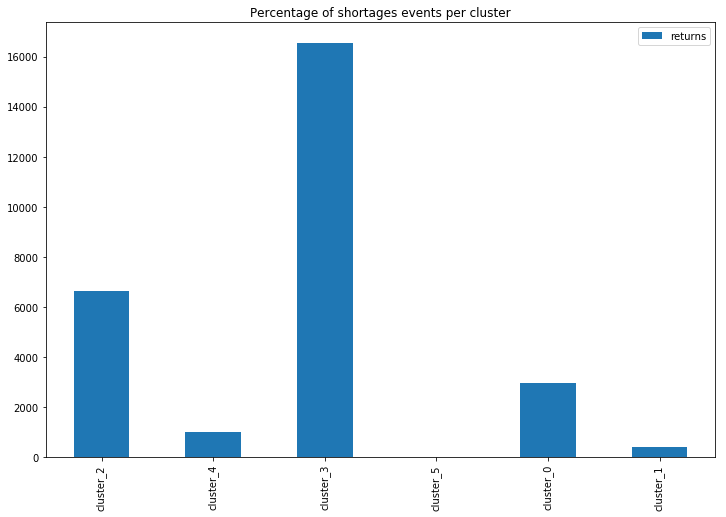

In [21]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

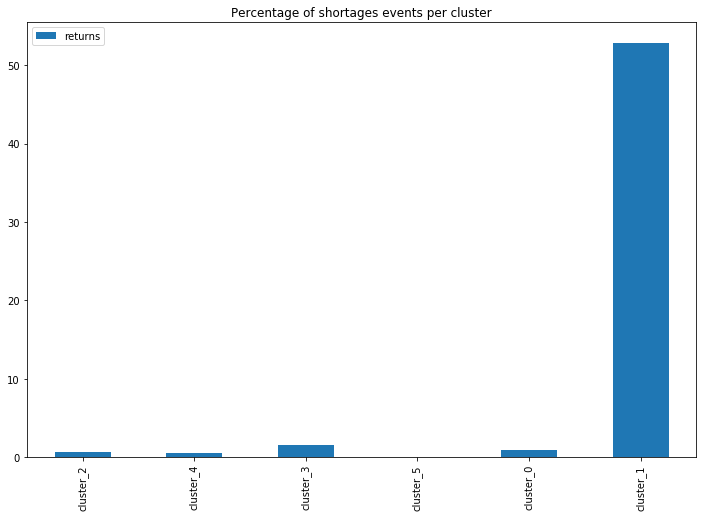

In [22]:
listy = {}
for a, i in df_dict.items():
    x = i[i['stock_open'] < 0]['stock_open'].count()/i['stock_open'].count()*100
    listy[a] = x
    
f, ax = plt.subplots(figsize=(12,8))
pd.DataFrame(listy, index=['returns']).T.plot(kind='bar', ax=ax)
plt.title('Percentage of shortages events per cluster')
plt.show()

Categorical variables per cluster



 sku_department


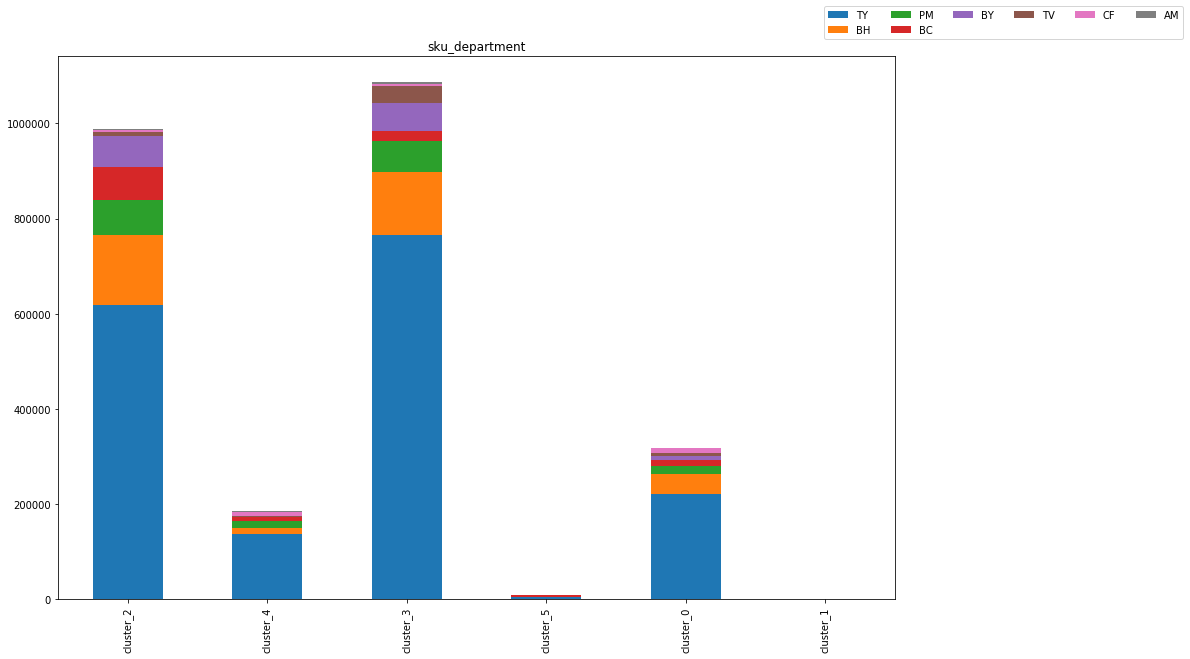



 sku_subdepartment


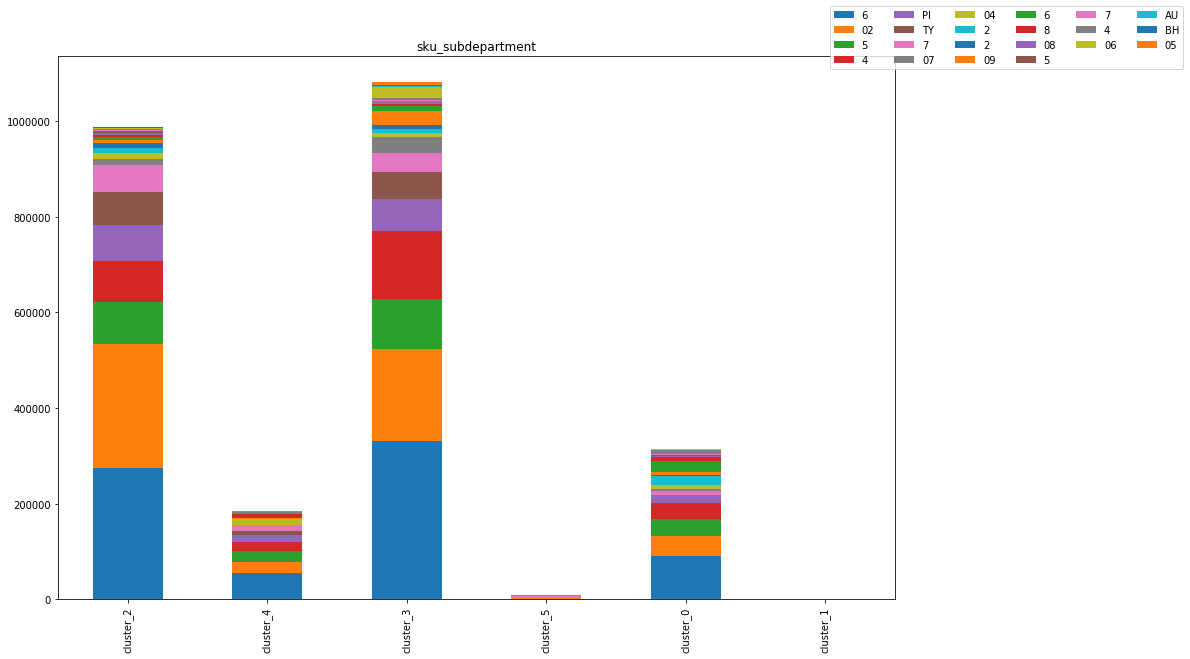



 sku_category


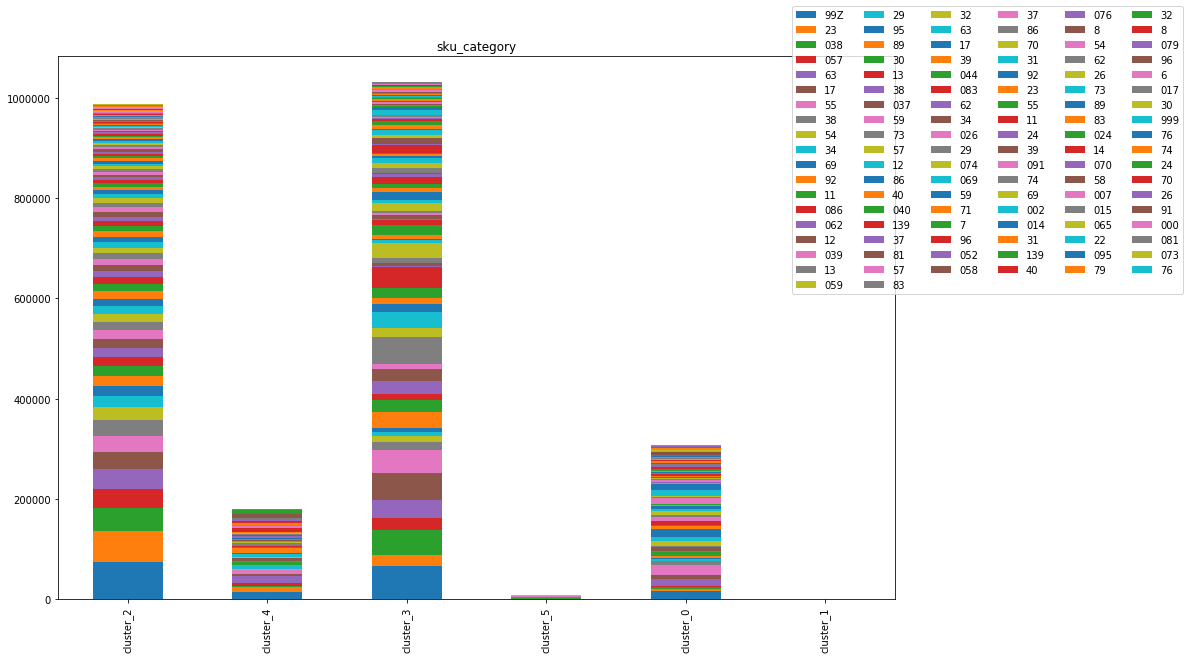



 sku_subcategory


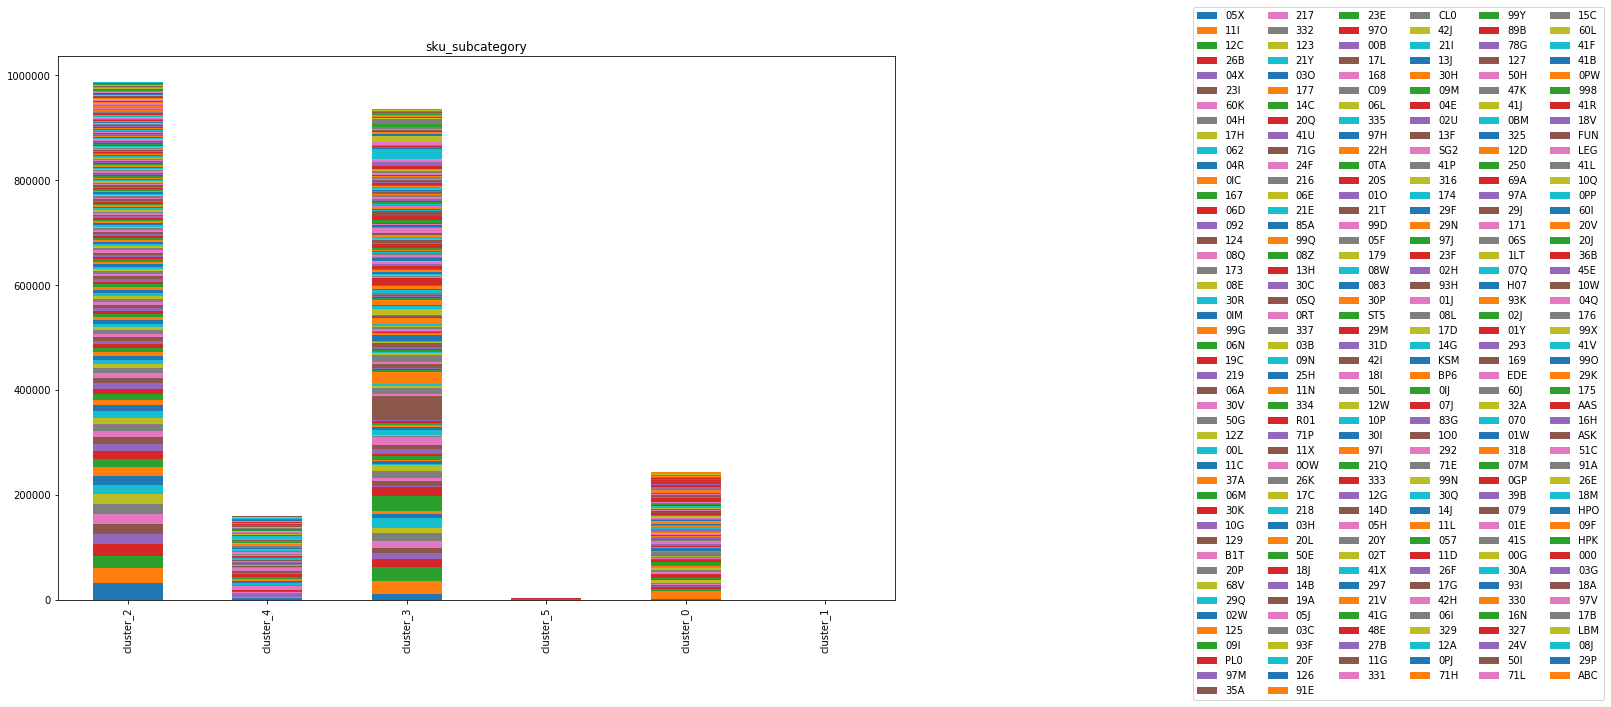



 sku_label


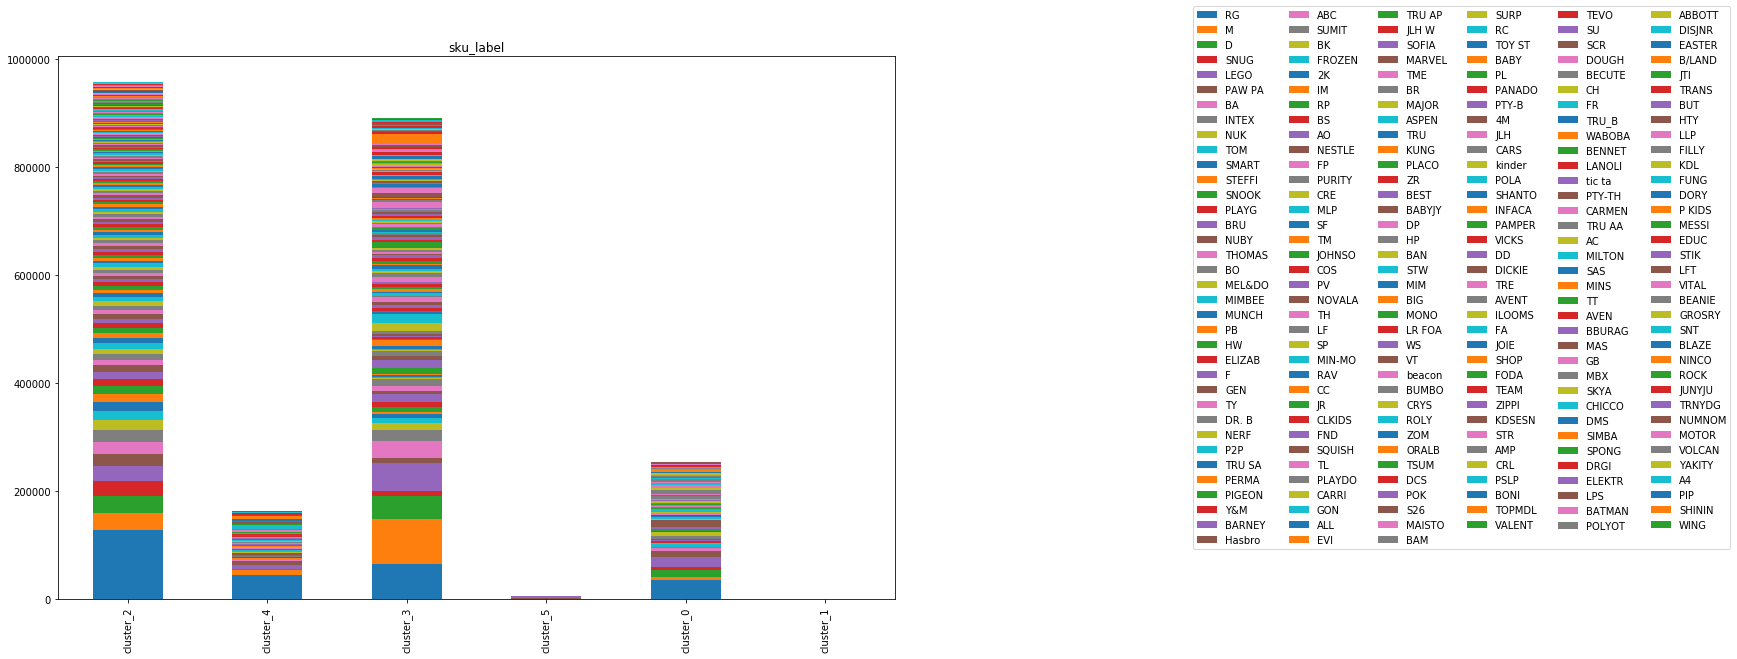

In [23]:
analyze_som.plot_cluster_categorical(df_dict, run_cats, True)

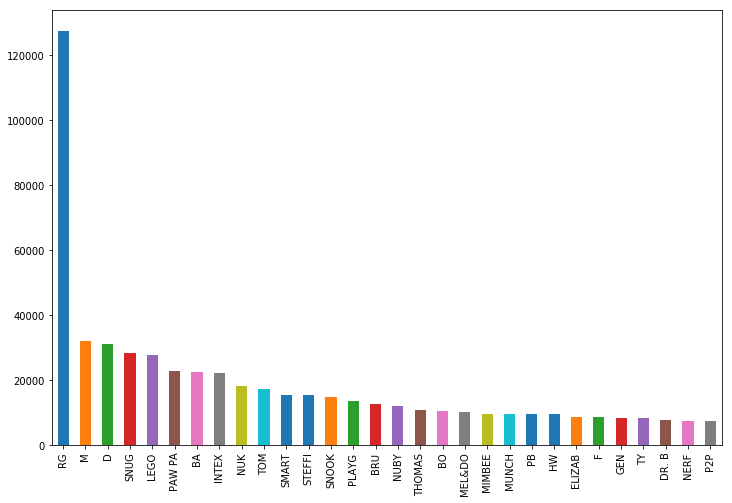

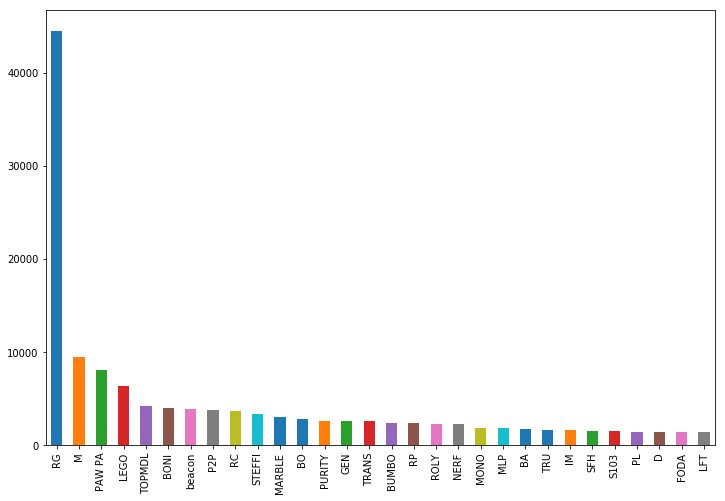

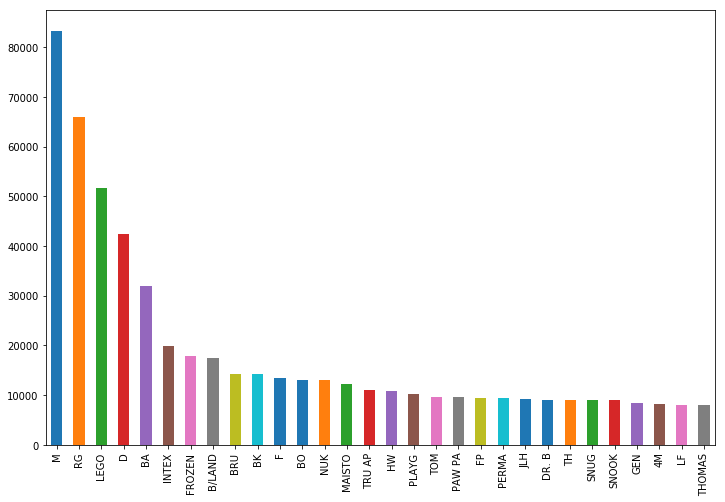

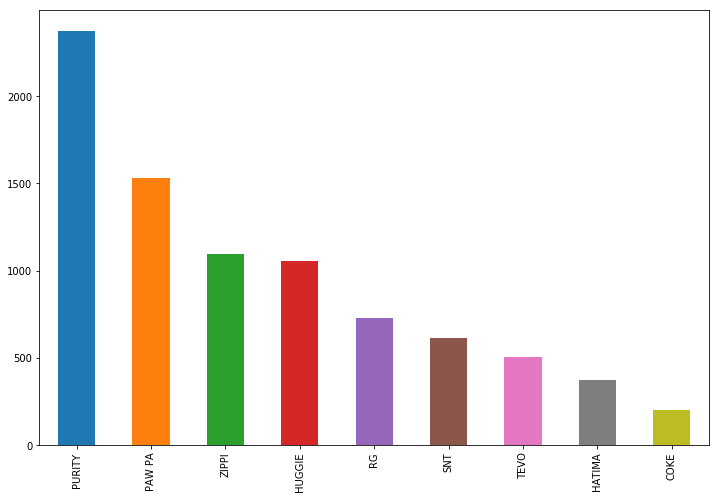

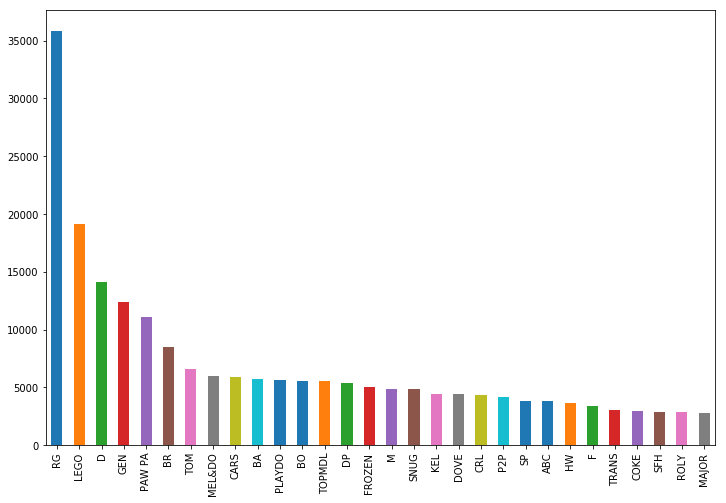

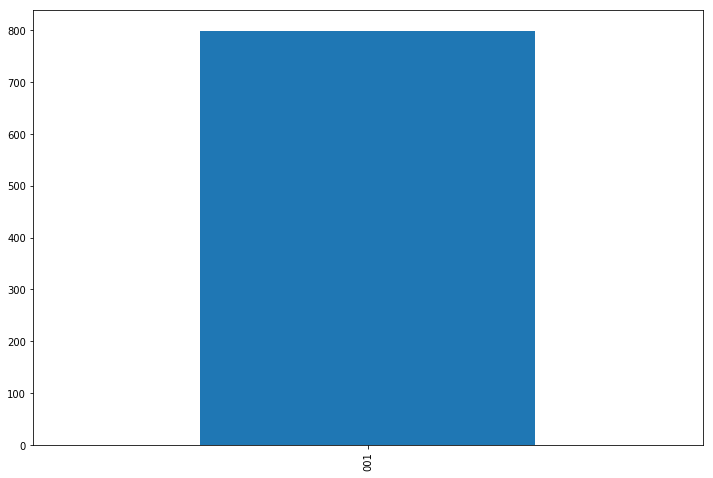

In [24]:
for i in df_dict.values():
    f = plt.figure(figsize=(12,8))
    i['sku_label'].value_counts()[:30].plot(kind='bar')
    plt.show()

Some messy inferential stats:

In [25]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq         df              F  PR(>F)
cluster   5.792558e+08        5.0  593642.563469     0.0
Residual  4.852490e+08  2486505.0            NaN     NaN 

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
  group1    group2   meandiff   lower     upper   reject
--------------------------------------------------------
cluster_0 cluster_1  833.7682  832.358   835.1783  True 
cluster_0 cluster_2   -0.312   -0.3932   -0.2307   True 
cluster_0 cluster_3  -1.6831   -1.7644   -1.6018   True 
cluster_0 cluster_4   5.5898    5.4734    5.7062   True 
cluster_0 cluster_5   42.257   41.8189   42.6952   True 
cluster_1 cluster_2 -834.0801  -835.489 -832.6712  True 
cluster_1 cluster_3 -835.4513 -836.8602 -834.0424  True 
cluster_1 cluster_4 -828.1784 -829.5898  -826.767  True 
cluster_1 cluster_5 -791.5111 -792.9844 -790.0379  True 
cluster_2 cluster_3  -1.3711   -1.4278   -1.3145   True 
cluster_2 cluster_4   5.9017    5.801     6.0025   True 
cluster_2 cluster_5

Now moving to cumulative sales per cluster

In [42]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

sku_key  sales         0         1  sales_log  cluster
0       28    122  6.603916 -1.519023   2.086360        3
1      102    153  9.735120  4.017874   2.184691        3
2      103     35  8.064100 -2.470729   1.544068        3
3      112    116  7.347979  4.776672   2.064458        0
4      148     89  5.858500  2.393169   1.949390        3

cluster 3
1701


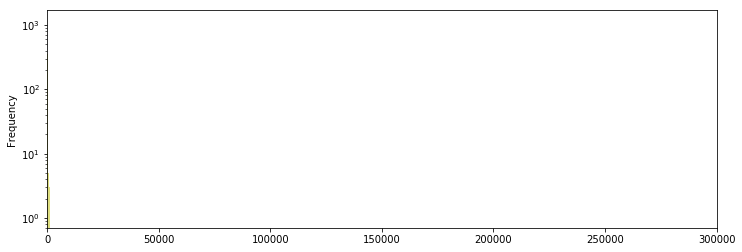

cluster 0
1113


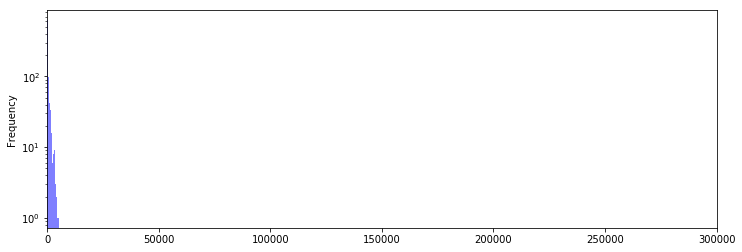

cluster 2
1422


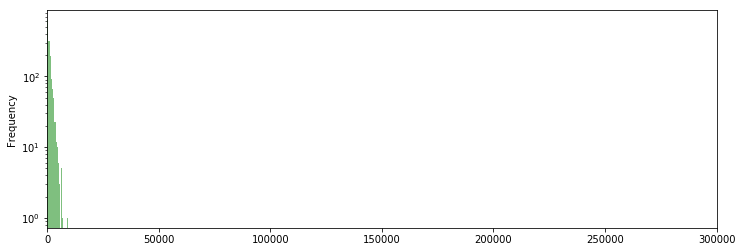

cluster 4
323


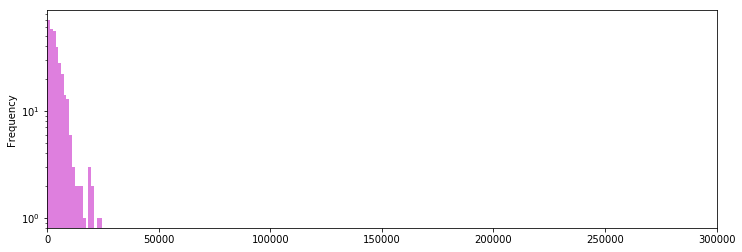

cluster 5
16


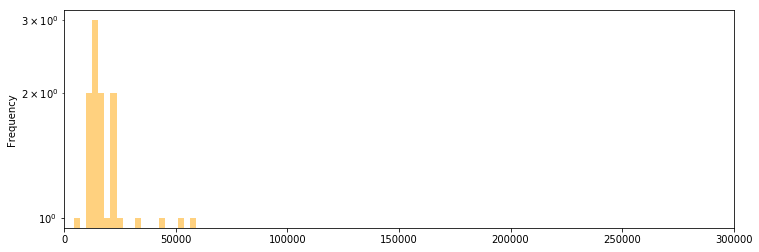

cluster 1
3


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


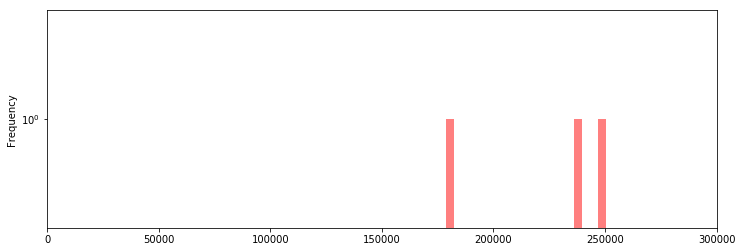

In [43]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 300000)
    plt.show()

In [44]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


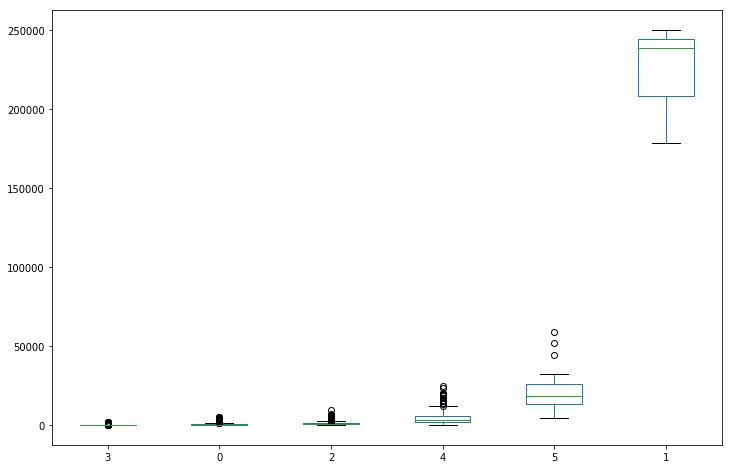

In [45]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)


In [46]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

cluster  value
0        3  122.0
1        3  153.0
2        3   35.0
4        3   89.0
5        3   82.0

In [47]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df          F    PR(>F)
cluster   5.531381e+08     1.0  14.572751  0.000137
Residual  1.736913e+11  4576.0        NaN       NaN


In [48]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
group1 group2   meandiff      lower        upper     reject
-----------------------------------------------------------
  0      1    222026.1941  219148.7985  224903.5897   True 
  0      2      535.8853     336.6955     735.0752    True 
  0      3      -419.763    -611.6467    -227.8794    True 
  0      4     3739.1435    3424.5831    4053.7039    True 
  0      5     22832.9024   21579.7177   24086.0871   True 
  1      2    -221490.3087 -224366.8638 -218613.7537  True 
  1      3    -222445.9571 -225322.0155 -219569.8987  True 
  1      4    -218287.0506 -221173.8898 -215400.2113  True 
  1      5    -199193.2917 -202324.6435 -196061.9398  True 
  2      3     -955.6484    -1134.4863   -776.8104    True 
  2      4     3203.2582    2896.4815    3510.0348    True 
  2      5     22297.0171   21045.7635   23548.2707   True 
  3      4     4158.9065    3856.8227    4460.9904    True 
  3      5     23252.6654   22002.5541  